[dataset_builder] loaded. Available names:
['generate_preferred_directions', 'generate_direction_encoding_dataset']
=== Experiment 1: Static directions, T=800.0 ms, N=40 ===
Dataset shape (spikes): (800, 800, 40)
Saved temp dataset to: exp1_static_T800.npz

[Experiment 1] Linear decoder (rate)
X_train shape: (640, 40) X_test shape: (160, 40)
y_train distribution: {0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 7: 80}
y_test  distribution: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20}
Logistic Regression train acc: 1.0000
Logistic Regression test  acc: 1.0000


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


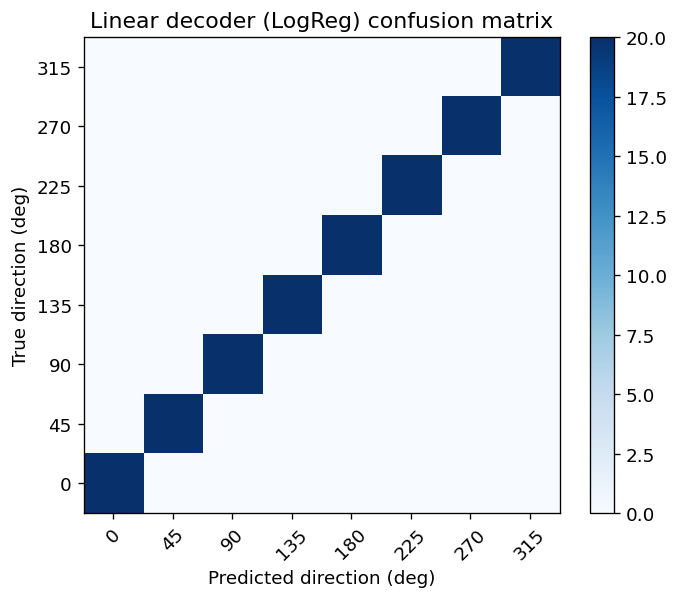


[Experiment 1] MLP decoder (rate)
Epoch   1 | loss 1.9058 | train acc 0.6891 | test acc 0.6687
Epoch   5 | loss 0.3313 | train acc 0.9984 | test acc 1.0000
Epoch  10 | loss 0.0337 | train acc 1.0000 | test acc 1.0000
Epoch  15 | loss 0.0143 | train acc 1.0000 | test acc 1.0000
Epoch  20 | loss 0.0082 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0052 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0037 | train acc 1.0000 | test acc 1.0000
Epoch  35 | loss 0.0027 | train acc 1.0000 | test acc 1.0000
Epoch  40 | loss 0.0021 | train acc 1.0000 | test acc 1.0000
Final MLP test accuracy: 1.0

[Experiment 1] SNN decoder (spike train)


KeyboardInterrupt: 

In [8]:
# ==== 实验 Notebook - 代码块 1 ====
# 公共导入 + 实验 1：静态方向 + 长时间窗（T=800ms）

import os
import numpy as np
import matplotlib.pyplot as plt

# 保证在项目根目录下运行 Notebook
# 目录结构中应该有 encoding/ 和 decoding/ 这些包
from encoding.dataset_builder import generate_direction_encoding_dataset
from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

# 让图更好看一点
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11


# ===================== 实验 1：静态方向 + 长时间窗 =====================

def run_experiment_static_long_T(
    T_ms=800.0,
    n_neurons=40,
    trials_per_dir=100,
    seed=0,
    save_tmp=True,
    tmp_path="exp1_static_T800.npz",
    n_epochs_mlp=40,
    n_epochs_snn=40,
):
    """
    实验 1：静态 8 方向 + 长时间窗（T=800ms）
    - Linear / MLP：输入 spike count
    - SNN：输入完整 spike train
    """

    directions = np.arange(0, 360, 45)  # 8 个方向
    print(f"=== Experiment 1: Static directions, T={T_ms} ms, N={n_neurons} ===")

    # 1) 生成数据（中等噪声）
    dataset = generate_direction_encoding_dataset(
        directions_deg=directions,
        n_neurons=n_neurons,
        trials_per_dir=trials_per_dir,
        T=T_ms,
        dt=1.0,
        r_baseline=8.0,
        r_max_mean=25.0,
        r_max_std=6.0,
        tuning_sigma_deg=50.0,
        jitter_pref_deg=7.0,
        gain_sigma=0.25,
        shared_std=3.0,
        indep_std=2.0,
        seed=seed,
    )

    spikes = dataset["spikes"]
    labels = dataset["labels"]
    directions_deg = dataset["directions_deg"]

    print("Dataset shape (spikes):", spikes.shape)

    # 2) 保存临时数据集，兼容 decoding 模块
    if save_tmp:
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )
        print("Saved temp dataset to:", tmp_path)
        dataset_path = tmp_path
    else:
        # 如果不保存，就直接写一个内存 npz 的替代接口（这里简单起见直接保存）
        raise NotImplementedError("建议保存成 npz 再用解码器")

    # 3) Linear 解码
    print("\n[Experiment 1] Linear decoder (rate)")
    _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
    )

    # 4) MLP 解码
    print("\n[Experiment 1] MLP decoder (rate)")
    _, (test_acc_mlp, _) = train_rate_mlp(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_mlp,
    )

    # 5) SNN 解码
    print("\n[Experiment 1] SNN decoder (spike train)")
    _, (test_acc_snn, _) = train_snn_decoder(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_snn,
    )

    # 6) 小总结条形图
    methods = ["Linear", "MLP (rate)", "SNN (spike)"]
    accs = [test_acc_lin, test_acc_mlp, test_acc_snn]

    plt.figure(figsize=(5, 4))
    plt.bar(methods, accs)
    plt.ylim(0, 1.05)
    plt.ylabel("Test accuracy")
    plt.title(f"Experiment 1: Static directions, T={T_ms} ms")
    for i, a in enumerate(accs):
        plt.text(i, a + 0.02, f"{a:.2f}", ha="center")
    plt.tight_layout()
    plt.show()

    return {
        "test_acc_lin": test_acc_lin,
        "test_acc_mlp": test_acc_mlp,
        "test_acc_snn": test_acc_snn,
    }


# 直接运行实验 1
results_exp1 = run_experiment_static_long_T()
results_exp1


=== Experiment 2: Two-segment stimulus, T1=100.0 ms, T2=100.0 ms, N=40 ===
Dataset shape (spikes): (1600, 200, 40)
Saved temp dataset to: exp2_two_segment_T100_100.npz

[Experiment 2] Linear decoder (whole-window rate)
X_train shape: (1280, 40) X_test shape: (320, 40)
y_train distribution: {0: 162, 1: 160, 2: 152, 3: 150, 4: 171, 5: 154, 6: 159, 7: 172}
y_test  distribution: {0: 40, 1: 40, 2: 38, 3: 37, 4: 43, 5: 39, 6: 40, 7: 43}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.5242
Logistic Regression test  acc: 0.3875


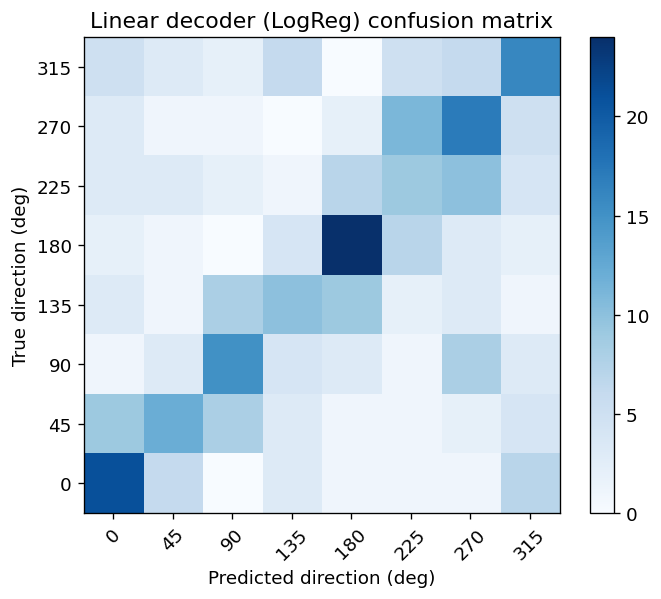


[Experiment 2] MLP decoder (whole-window rate)
Epoch   1 | loss 1.9804 | train acc 0.3383 | test acc 0.2844
Epoch   5 | loss 1.3744 | train acc 0.4711 | test acc 0.3937
Epoch  10 | loss 1.1853 | train acc 0.5820 | test acc 0.4437
Epoch  15 | loss 1.0535 | train acc 0.6398 | test acc 0.4281
Epoch  20 | loss 0.9198 | train acc 0.6930 | test acc 0.4125
Epoch  25 | loss 0.7861 | train acc 0.7461 | test acc 0.3906
Epoch  30 | loss 0.6490 | train acc 0.8164 | test acc 0.4188
Epoch  35 | loss 0.5185 | train acc 0.8711 | test acc 0.4125
Epoch  40 | loss 0.4016 | train acc 0.9141 | test acc 0.4000
Final MLP test accuracy: 0.4

[Experiment 2] SNN decoder (spike train, time-structure)
Epoch   1 | loss 5.5270 | train acc 0.1688 | test acc 0.1344
Epoch   5 | loss 1.5648 | train acc 0.3844 | test acc 0.3719
Epoch  10 | loss 1.3834 | train acc 0.4805 | test acc 0.4031
Epoch  15 | loss 1.2364 | train acc 0.5320 | test acc 0.4031
Epoch  20 | loss 1.1666 | train acc 0.5430 | test acc 0.4344
Epoch  25 |

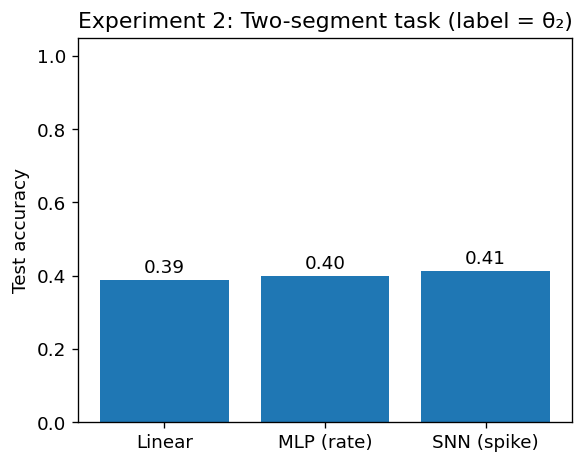

{'test_acc_lin': 0.3875, 'test_acc_mlp': 0.4, 'test_acc_snn': 0.4125}

In [ ]:
# ==== 实验 Notebook - 代码块 2 ====
# 实验 2：短时间窗 + 方向快速变化（两段不同方向，标签为后半段方向）

from encoding.tuning import (
    generate_preferred_directions,
    sample_r_max,
    direction_tuning_gaussian,
)
from encoding.poisson_spike import poisson_population_spikes


def generate_two_segment_direction_dataset(
    directions_deg,
    n_neurons=40,
    trials_total=800,
    T1=100.0,
    T2=100.0,
    dt=1.0,
    r_baseline=8.0,
    r_max_mean=25.0,
    r_max_std=6.0,
    tuning_sigma_deg=50.0,
    jitter_pref_deg=7.0,
    gain_sigma=0.25,
    shared_std=3.0,
    indep_std=2.0,
    seed=123,
):
    """
    生成“前后两段不同方向”的时间相关数据集。

    每个 trial：
    - 前 T1 ms：方向 theta1
    - 后 T2 ms：方向 theta2
    - 标签：theta2 对应的方向类别 idx

    返回：
    - spikes : (n_examples, T_steps_total, n_neurons)
    - labels : (n_examples,)
    - directions_deg : (n_dirs,)
    """
    rng = np.random.default_rng(seed)
    directions_deg = np.asarray(directions_deg)
    n_dirs = directions_deg.shape[0]
    T1_steps = int(T1 / dt)
    T2_steps = int(T2 / dt)
    T_steps_total = T1_steps + T2_steps

    # Population 参数
    theta_prefs = generate_preferred_directions(
        n_neurons=n_neurons,
        jitter_deg=jitter_pref_deg,
        seed=rng.integers(1_000_000_000),
    )
    r_max = sample_r_max(
        n_neurons=n_neurons,
        r_max_mean=r_max_mean,
        r_max_std=r_max_std,
        min_rate=1.0,
        max_rate=None,
        seed=rng.integers(1_000_000_000),
    )

    # 预先算好 tuning
    base_rates_all = direction_tuning_gaussian(
        theta_stim_deg=directions_deg,
        theta_pref_deg=theta_prefs,
        r_baseline=r_baseline,
        r_max=r_max,
        sigma_deg=tuning_sigma_deg,
    )  # (n_dirs, n_neurons)

    spikes = np.zeros((trials_total, T_steps_total, n_neurons), dtype=np.uint8)
    labels = np.zeros(trials_total, dtype=np.int64)
    theta1_idx_all = rng.integers(low=0, high=n_dirs, size=trials_total)
    theta2_idx_all = rng.integers(low=0, high=n_dirs, size=trials_total)

    for i in range(trials_total):
        d1_idx = theta1_idx_all[i]
        d2_idx = theta2_idx_all[i]

        rates1 = base_rates_all[d1_idx].copy()
        rates2 = base_rates_all[d2_idx].copy()

        # trial-by-trial 噪声我们分别对两个段加（也可以只在整个 trial 上加一次）
        def apply_noise(rates_segment):
            rates = rates_segment.copy()
            if gain_sigma > 0.0:
                gain = rng.lognormal(mean=0.0, sigma=gain_sigma)
                rates *= gain
            if shared_std > 0.0:
                rates += rng.normal(0.0, shared_std)
            if indep_std > 0.0:
                rates += rng.normal(0.0, indep_std, size=n_neurons)
            return np.clip(rates, 0.0, None)

        rates1_noisy = apply_noise(rates1)
        rates2_noisy = apply_noise(rates2)

        spikes1 = poisson_population_spikes(
            rates_hz=rates1_noisy,
            T=T1,
            dt=dt,
            rng=rng,
        )  # (T1_steps, n_neurons)
        spikes2 = poisson_population_spikes(
            rates_hz=rates2_noisy,
            T=T2,
            dt=dt,
            rng=rng,
        )  # (T2_steps, n_neurons)

        spikes[i, :T1_steps] = spikes1
        spikes[i, T1_steps:] = spikes2
        labels[i] = d2_idx  # 标签 = 后半段方向

    meta = {
        "T_total": T1 + T2,
        "T1": T1,
        "T2": T2,
        "dt": dt,
        "r_baseline": r_baseline,
        "r_max_mean": r_max_mean,
        "r_max_std": r_max_std,
        "tuning_sigma_deg": tuning_sigma_deg,
        "jitter_pref_deg": jitter_pref_deg,
        "gain_sigma": gain_sigma,
        "shared_std": shared_std,
        "indep_std": indep_std,
        "n_neurons": n_neurons,
        "trials_total": trials_total,
        "seed": seed,
        "task": "decode_second_segment_direction",
    }

    return {
        "spikes": spikes,
        "labels": labels,
        "directions_deg": directions_deg,
        "theta_prefs": theta_prefs,
        "r_max": r_max,
        "meta": meta,
    }


def run_experiment_two_segment(
    T1=100.0,
    T2=100.0,
    n_neurons=40,
    trials_total=1600,
    seed=1,
    tmp_path="exp2_two_segment_T100_100.npz",
    n_epochs_mlp=40,
    n_epochs_snn=40,
):
    """
    实验 2：短时间窗 + 方向快速变化（两段不同方向，标签为后半段方向）
    """

    directions = np.arange(0, 360, 45)
    print(
        f"=== Experiment 2: Two-segment stimulus, "
        f"T1={T1} ms, T2={T2} ms, N={n_neurons} ==="
    )

    dataset = generate_two_segment_direction_dataset(
        directions_deg=directions,
        n_neurons=n_neurons,
        trials_total=trials_total,
        T1=T1,
        T2=T2,
        dt=1.0,
        seed=seed,
    )

    spikes = dataset["spikes"]
    labels = dataset["labels"]
    directions_deg = dataset["directions_deg"]
    print("Dataset shape (spikes):", spikes.shape)

    np.savez(
        tmp_path,
        spikes=spikes,
        labels=labels,
        directions_deg=directions_deg,
        meta=np.array([dataset["meta"]], dtype=object),
    )
    print("Saved temp dataset to:", tmp_path)

    # 1) Linear 解码（rate+whole-window）
    print("\n[Experiment 2] Linear decoder (whole-window rate)")
    _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
    )

    # 2) MLP 解码
    print("\n[Experiment 2] MLP decoder (whole-window rate)")
    _, (test_acc_mlp, _) = train_rate_mlp(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_mlp,
    )

    # 3) SNN 解码（完整 spike train，能利用时间结构）
    print("\n[Experiment 2] SNN decoder (spike train, time-structure)")
    _, (test_acc_snn, _) = train_snn_decoder(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_snn,
    )

    methods = ["Linear", "MLP (rate)", "SNN (spike)"]
    accs = [test_acc_lin, test_acc_mlp, test_acc_snn]

    plt.figure(figsize=(5, 4))
    plt.bar(methods, accs)
    plt.ylim(0, 1.05)
    plt.ylabel("Test accuracy")
    plt.title(f"Experiment 2: Two-segment task (label = θ₂)")
    for i, a in enumerate(accs):
        plt.text(i, a + 0.02, f"{a:.2f}", ha="center")
    plt.tight_layout()
    plt.show()

    return {
        "test_acc_lin": test_acc_lin,
        "test_acc_mlp": test_acc_mlp,
        "test_acc_snn": test_acc_snn,
    }


# 直接运行实验 2
results_exp2 = run_experiment_two_segment()
results_exp2



[Sweep N] N_neurons = 10
X_train shape: (640, 10) X_test shape: (160, 10)
y_train distribution: {0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 7: 80}
y_test  distribution: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8844
Logistic Regression test  acc: 0.8063


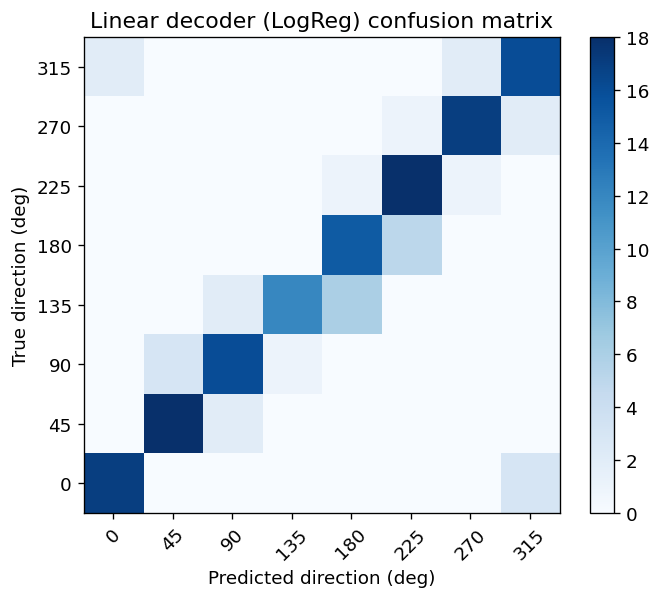

Epoch   1 | loss 2.0183 | train acc 0.5766 | test acc 0.5625
Epoch   5 | loss 0.9429 | train acc 0.8547 | test acc 0.8000
Epoch  10 | loss 0.4261 | train acc 0.8688 | test acc 0.8625
Epoch  15 | loss 0.3378 | train acc 0.8828 | test acc 0.8500
Epoch  20 | loss 0.2976 | train acc 0.8922 | test acc 0.8562
Epoch  25 | loss 0.2723 | train acc 0.8906 | test acc 0.8313
Epoch  30 | loss 0.2522 | train acc 0.8969 | test acc 0.8750
Final MLP test accuracy: 0.875
Epoch   1 | loss 10.1260 | train acc 0.1594 | test acc 0.1500
Epoch   5 | loss 1.5718 | train acc 0.4703 | test acc 0.4125
Epoch  10 | loss 0.8556 | train acc 0.6859 | test acc 0.6687
Epoch  15 | loss 0.7769 | train acc 0.7422 | test acc 0.7125
Epoch  20 | loss 0.5897 | train acc 0.7453 | test acc 0.6562
Epoch  25 | loss 0.5638 | train acc 0.7156 | test acc 0.6875
Epoch  30 | loss 0.4940 | train acc 0.8187 | test acc 0.8250
Final SNN test accuracy: 0.825

[Sweep N] N_neurons = 20
X_train shape: (640, 20) X_test shape: (160, 20)
y_train 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


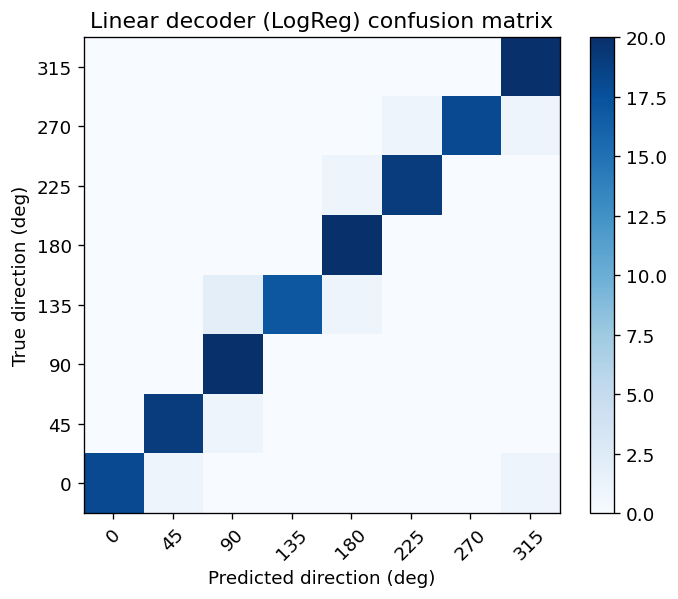

Epoch   1 | loss 1.9816 | train acc 0.5828 | test acc 0.5625
Epoch   5 | loss 0.6631 | train acc 0.9625 | test acc 0.9563
Epoch  10 | loss 0.1530 | train acc 0.9766 | test acc 0.9625
Epoch  15 | loss 0.0898 | train acc 0.9812 | test acc 0.9750
Epoch  20 | loss 0.0665 | train acc 0.9891 | test acc 0.9688
Epoch  25 | loss 0.0529 | train acc 0.9906 | test acc 0.9688
Epoch  30 | loss 0.0428 | train acc 0.9938 | test acc 0.9688
Final MLP test accuracy: 0.96875
Epoch   1 | loss 9.0212 | train acc 0.1844 | test acc 0.1812
Epoch   5 | loss 0.9350 | train acc 0.7344 | test acc 0.7188
Epoch  10 | loss 0.4941 | train acc 0.9031 | test acc 0.8562
Epoch  15 | loss 0.2962 | train acc 0.9047 | test acc 0.9313
Epoch  20 | loss 0.2486 | train acc 0.9484 | test acc 0.9437
Epoch  25 | loss 0.2055 | train acc 0.9344 | test acc 0.9250
Epoch  30 | loss 0.1794 | train acc 0.9625 | test acc 0.9500
Final SNN test accuracy: 0.95

[Sweep N] N_neurons = 40
X_train shape: (640, 40) X_test shape: (160, 40)
y_train 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


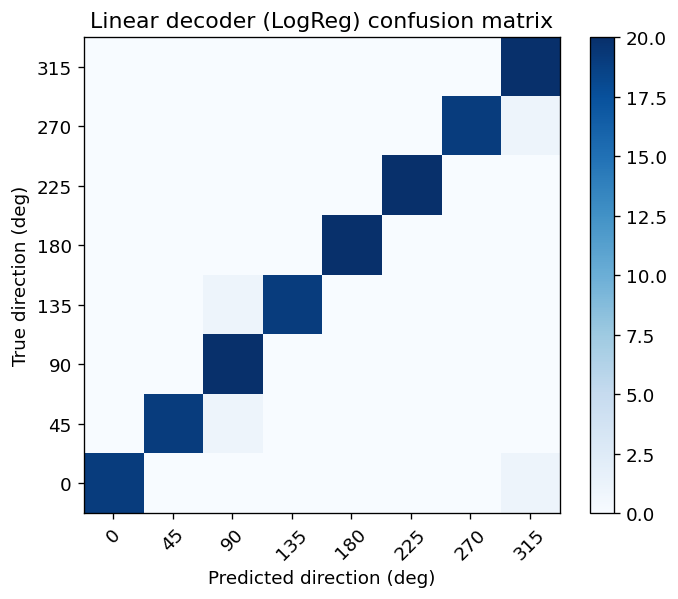

Epoch   1 | loss 1.9845 | train acc 0.5906 | test acc 0.6000
Epoch   5 | loss 0.4534 | train acc 0.9984 | test acc 0.9875
Epoch  10 | loss 0.0470 | train acc 0.9984 | test acc 0.9875
Epoch  15 | loss 0.0199 | train acc 1.0000 | test acc 0.9875
Epoch  20 | loss 0.0112 | train acc 1.0000 | test acc 0.9875
Epoch  25 | loss 0.0073 | train acc 1.0000 | test acc 0.9875
Epoch  30 | loss 0.0050 | train acc 1.0000 | test acc 0.9875
Final MLP test accuracy: 0.9875
Epoch   1 | loss 28.0392 | train acc 0.1219 | test acc 0.0875
Epoch   5 | loss 0.8780 | train acc 0.7031 | test acc 0.6500
Epoch  10 | loss 0.2625 | train acc 0.9641 | test acc 0.9437
Epoch  15 | loss 0.1278 | train acc 0.9875 | test acc 0.9625
Epoch  20 | loss 0.0800 | train acc 0.9922 | test acc 0.9500
Epoch  25 | loss 0.0520 | train acc 0.9969 | test acc 0.9563
Epoch  30 | loss 0.0344 | train acc 0.9984 | test acc 0.9875
Final SNN test accuracy: 0.9875

[Sweep N] N_neurons = 80
X_train shape: (640, 80) X_test shape: (160, 80)
y_trai

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 1.0000
Logistic Regression test  acc: 1.0000


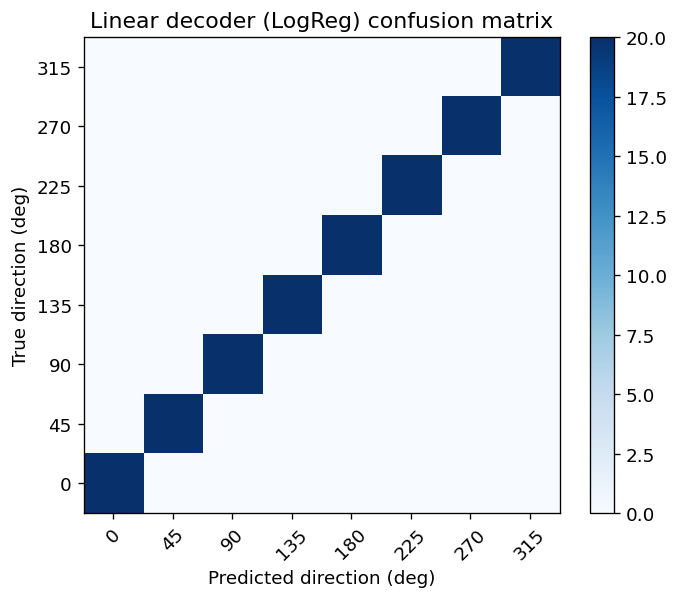

Epoch   1 | loss 1.9101 | train acc 0.6937 | test acc 0.7063
Epoch   5 | loss 0.1416 | train acc 1.0000 | test acc 1.0000
Epoch  10 | loss 0.0152 | train acc 1.0000 | test acc 1.0000
Epoch  15 | loss 0.0071 | train acc 1.0000 | test acc 1.0000
Epoch  20 | loss 0.0042 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0028 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0020 | train acc 1.0000 | test acc 1.0000
Final MLP test accuracy: 1.0
Epoch   1 | loss 11.0762 | train acc 0.2828 | test acc 0.3125
Epoch   5 | loss 0.3659 | train acc 0.9547 | test acc 0.9437
Epoch  10 | loss 0.0570 | train acc 1.0000 | test acc 0.9938
Epoch  15 | loss 0.0258 | train acc 1.0000 | test acc 1.0000
Epoch  20 | loss 0.0139 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0086 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0057 | train acc 1.0000 | test acc 1.0000
Final SNN test accuracy: 1.0

[Sweep sigma] sigma = 30.0 deg
X_train shape: (640, 40) X_test shape: (160, 40)
y_trai

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


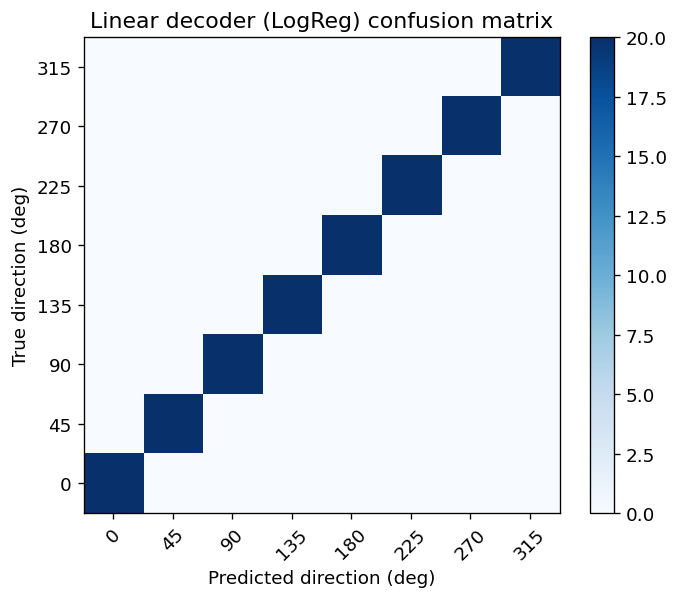

Epoch   1 | loss 1.9365 | train acc 0.8984 | test acc 0.9187
Epoch   5 | loss 0.3155 | train acc 0.9953 | test acc 1.0000
Epoch  10 | loss 0.0322 | train acc 1.0000 | test acc 1.0000
Epoch  15 | loss 0.0149 | train acc 1.0000 | test acc 1.0000
Epoch  20 | loss 0.0087 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0057 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0040 | train acc 1.0000 | test acc 1.0000
Final MLP test accuracy: 1.0
Epoch   1 | loss 22.4696 | train acc 0.1969 | test acc 0.2062
Epoch   5 | loss 0.6831 | train acc 0.8922 | test acc 0.8875
Epoch  10 | loss 0.0941 | train acc 0.9953 | test acc 0.9812
Epoch  15 | loss 0.0343 | train acc 0.9969 | test acc 0.9938
Epoch  20 | loss 0.0185 | train acc 0.9984 | test acc 0.9938
Epoch  25 | loss 0.0099 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0070 | train acc 1.0000 | test acc 1.0000
Final SNN test accuracy: 1.0

[Sweep sigma] sigma = 45.0 deg
X_train shape: (640, 40) X_test shape: (160, 40)
y_trai

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


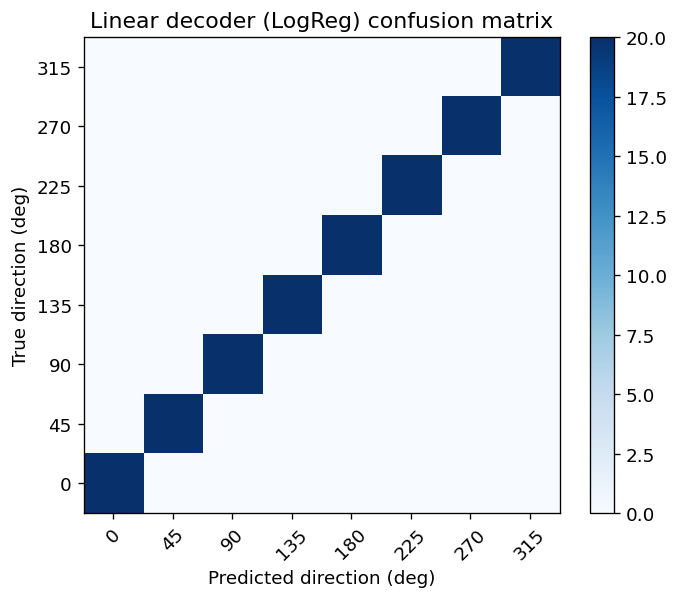

Epoch   1 | loss 1.9479 | train acc 0.6141 | test acc 0.6375
Epoch   5 | loss 0.3639 | train acc 0.9984 | test acc 1.0000
Epoch  10 | loss 0.0475 | train acc 0.9969 | test acc 1.0000
Epoch  15 | loss 0.0219 | train acc 0.9984 | test acc 1.0000
Epoch  20 | loss 0.0126 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0081 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0056 | train acc 1.0000 | test acc 1.0000
Final MLP test accuracy: 1.0
Epoch   1 | loss 13.8862 | train acc 0.1828 | test acc 0.1812
Epoch   5 | loss 0.7882 | train acc 0.8250 | test acc 0.8313
Epoch  10 | loss 0.1688 | train acc 0.9906 | test acc 0.9750
Epoch  15 | loss 0.0691 | train acc 0.9953 | test acc 0.9938
Epoch  20 | loss 0.0401 | train acc 0.9969 | test acc 0.9938
Epoch  25 | loss 0.0261 | train acc 1.0000 | test acc 0.9938
Epoch  30 | loss 0.0189 | train acc 1.0000 | test acc 1.0000
Final SNN test accuracy: 1.0

[Sweep sigma] sigma = 60.0 deg
X_train shape: (640, 40) X_test shape: (160, 40)
y_trai

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


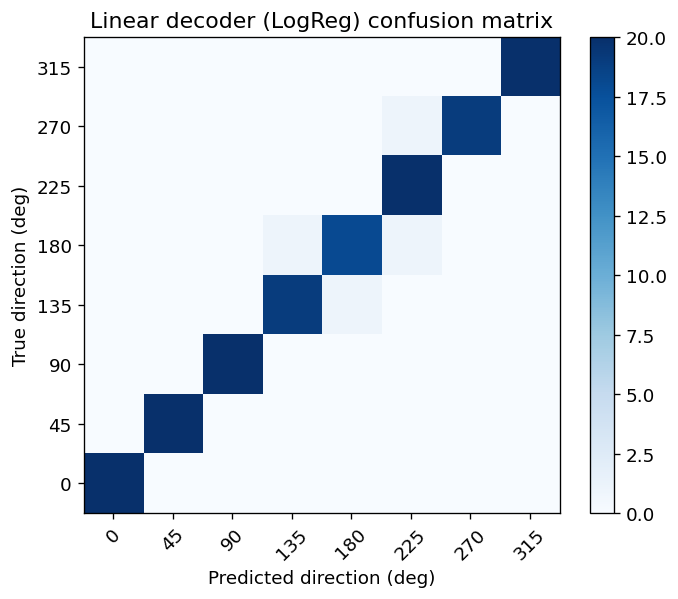

Epoch   1 | loss 1.9727 | train acc 0.6641 | test acc 0.6438
Epoch   5 | loss 0.3757 | train acc 0.9938 | test acc 0.9938
Epoch  10 | loss 0.0540 | train acc 0.9969 | test acc 0.9875
Epoch  15 | loss 0.0254 | train acc 1.0000 | test acc 0.9875
Epoch  20 | loss 0.0147 | train acc 1.0000 | test acc 0.9938
Epoch  25 | loss 0.0095 | train acc 1.0000 | test acc 0.9875
Epoch  30 | loss 0.0065 | train acc 1.0000 | test acc 0.9938
Final MLP test accuracy: 0.99375
Epoch   1 | loss 14.0955 | train acc 0.2062 | test acc 0.2313
Epoch   5 | loss 0.9377 | train acc 0.7156 | test acc 0.6813
Epoch  10 | loss 0.2932 | train acc 0.9453 | test acc 0.9313
Epoch  15 | loss 0.1202 | train acc 0.9812 | test acc 0.9625
Epoch  20 | loss 0.0621 | train acc 0.9984 | test acc 0.9875
Epoch  25 | loss 0.0457 | train acc 0.9984 | test acc 0.9938
Epoch  30 | loss 0.0344 | train acc 0.9984 | test acc 0.9938
Final SNN test accuracy: 0.99375

[Sweep noise] noise_level = 0.0
X_train shape: (640, 40) X_test shape: (160, 4

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 1.0000
Logistic Regression test  acc: 1.0000


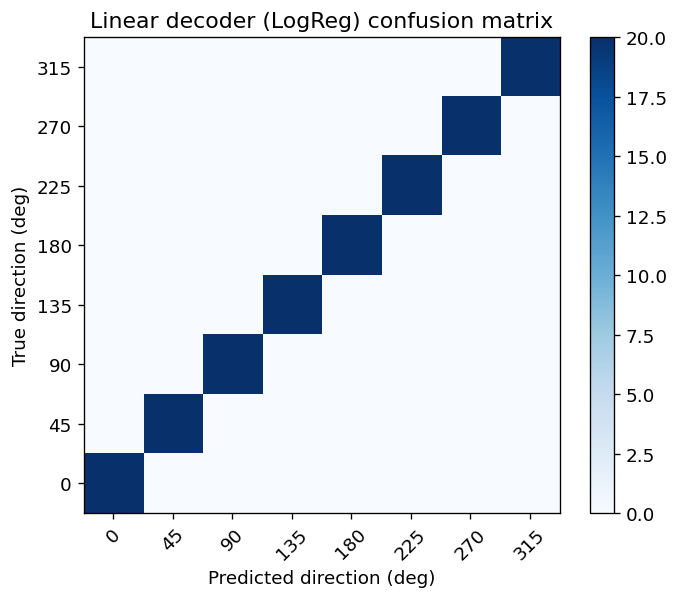

Epoch   1 | loss 1.9408 | train acc 0.6469 | test acc 0.5938
Epoch   5 | loss 0.3368 | train acc 0.9969 | test acc 1.0000
Epoch  10 | loss 0.0343 | train acc 1.0000 | test acc 1.0000
Epoch  15 | loss 0.0148 | train acc 1.0000 | test acc 1.0000
Epoch  20 | loss 0.0084 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0055 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0038 | train acc 1.0000 | test acc 1.0000
Final MLP test accuracy: 1.0
Epoch   1 | loss 12.0958 | train acc 0.1828 | test acc 0.1812
Epoch   5 | loss 0.6083 | train acc 0.8391 | test acc 0.8500
Epoch  10 | loss 0.1958 | train acc 0.9828 | test acc 0.9750
Epoch  15 | loss 0.1029 | train acc 0.9969 | test acc 0.9812
Epoch  20 | loss 0.0433 | train acc 0.9953 | test acc 0.9938
Epoch  25 | loss 0.0318 | train acc 0.9984 | test acc 0.9938
Epoch  30 | loss 0.0183 | train acc 1.0000 | test acc 1.0000
Final SNN test accuracy: 1.0

[Sweep noise] noise_level = 0.2
X_train shape: (640, 40) X_test shape: (160, 40)
y_tra

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


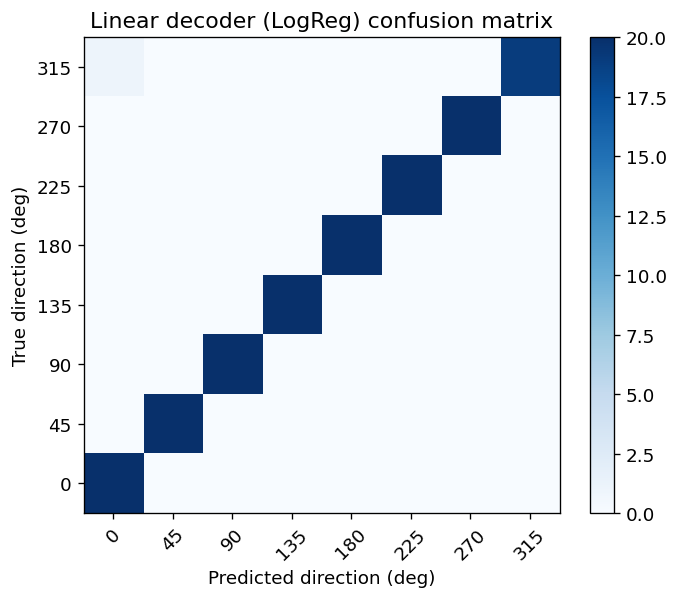

Epoch   1 | loss 1.9687 | train acc 0.7328 | test acc 0.6750
Epoch   5 | loss 0.3300 | train acc 0.9984 | test acc 0.9875
Epoch  10 | loss 0.0341 | train acc 1.0000 | test acc 0.9875
Epoch  15 | loss 0.0148 | train acc 1.0000 | test acc 0.9875
Epoch  20 | loss 0.0084 | train acc 1.0000 | test acc 0.9938
Epoch  25 | loss 0.0055 | train acc 1.0000 | test acc 0.9875
Epoch  30 | loss 0.0038 | train acc 1.0000 | test acc 0.9938
Final MLP test accuracy: 0.99375
Epoch   1 | loss 22.6202 | train acc 0.1609 | test acc 0.2062
Epoch   5 | loss 0.9165 | train acc 0.7422 | test acc 0.7500
Epoch  10 | loss 0.2319 | train acc 0.9734 | test acc 0.9563
Epoch  15 | loss 0.0824 | train acc 0.9906 | test acc 0.9938
Epoch  20 | loss 0.0428 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0297 | train acc 0.9984 | test acc 1.0000
Epoch  30 | loss 0.0198 | train acc 1.0000 | test acc 1.0000
Final SNN test accuracy: 1.0

[Sweep noise] noise_level = 0.4
X_train shape: (640, 40) X_test shape: (160, 40)
y

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


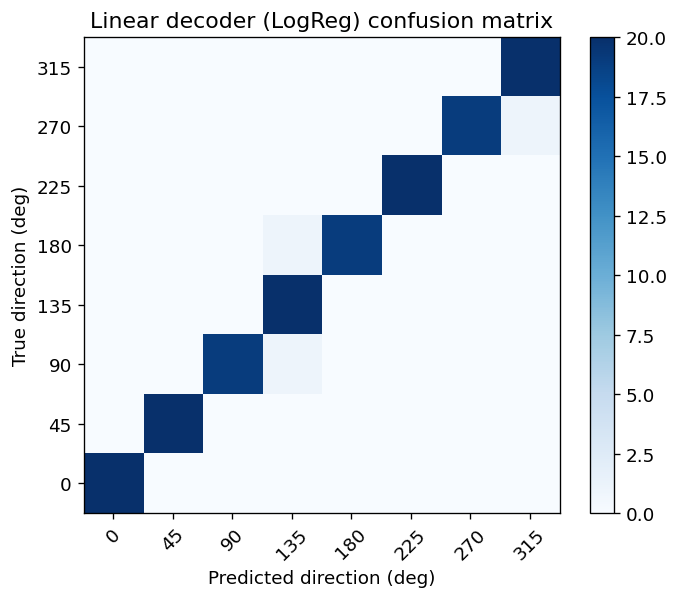

Epoch   1 | loss 1.9738 | train acc 0.7063 | test acc 0.7125
Epoch   5 | loss 0.5208 | train acc 0.9953 | test acc 1.0000
Epoch  10 | loss 0.0711 | train acc 0.9969 | test acc 1.0000
Epoch  15 | loss 0.0323 | train acc 0.9984 | test acc 1.0000
Epoch  20 | loss 0.0187 | train acc 0.9984 | test acc 0.9938
Epoch  25 | loss 0.0114 | train acc 1.0000 | test acc 0.9938
Epoch  30 | loss 0.0080 | train acc 1.0000 | test acc 0.9938
Final MLP test accuracy: 0.99375
Epoch   1 | loss 10.6369 | train acc 0.1219 | test acc 0.1125
Epoch   5 | loss 0.8216 | train acc 0.7578 | test acc 0.7500
Epoch  10 | loss 0.2952 | train acc 0.9719 | test acc 0.9563
Epoch  15 | loss 0.1245 | train acc 0.9875 | test acc 0.9812
Epoch  20 | loss 0.0727 | train acc 0.9922 | test acc 0.9812
Epoch  25 | loss 0.0501 | train acc 0.9984 | test acc 0.9938
Epoch  30 | loss 0.0334 | train acc 1.0000 | test acc 0.9812
Final SNN test accuracy: 0.98125


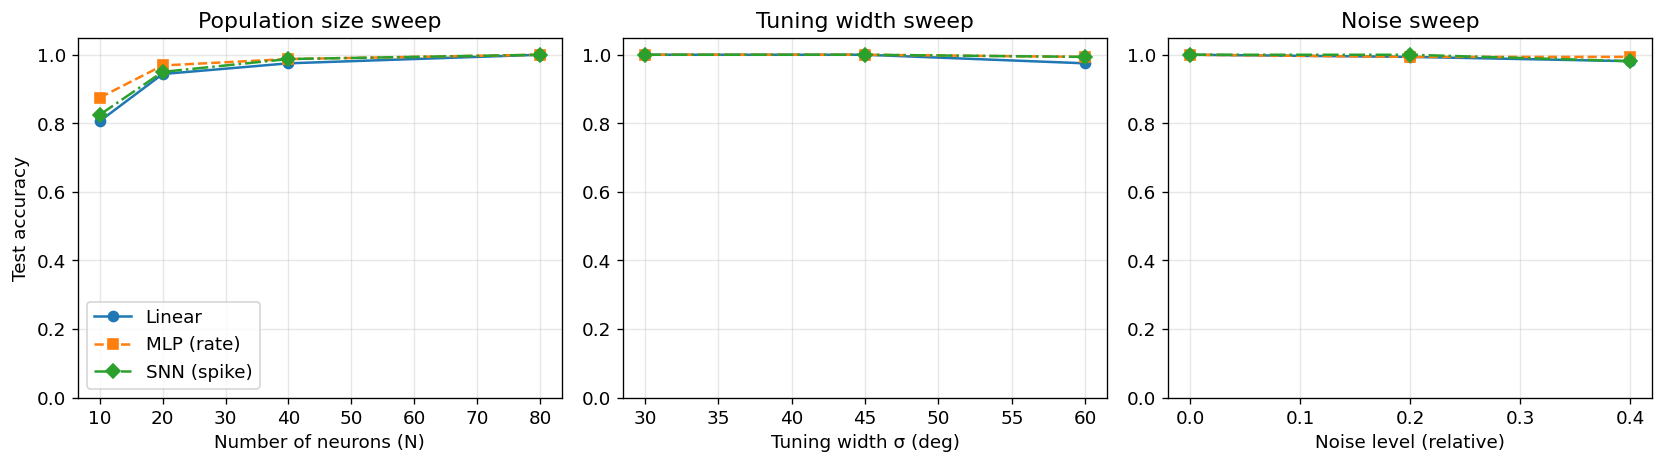

In [ ]:
# ==== 实验 Notebook - 代码块 3 ====
# 实验 3：population size / tuning width / 噪声强度 sweep

def sweep_population_size(
    N_list=(10, 20, 40, 80),
    T_ms=400.0,
    trials_per_dir=100,
    base_seed=100,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, N in enumerate(N_list):
        print("\n" + "=" * 60)
        print(f"[Sweep N] N_neurons = {N}")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=N,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=50.0,
            jitter_pref_deg=7.0,
            gain_sigma=0.25,
            shared_std=3.0,
            indep_std=2.0,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_N_{N}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        # Linear
        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        # MLP
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        # SNN
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    N_arr = np.array(N_list, dtype=int)
    return N_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


def sweep_tuning_sigma(
    sigma_list=(30.0, 45.0, 60.0),
    T_ms=400.0,
    n_neurons=40,
    trials_per_dir=100,
    base_seed=200,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, sigma in enumerate(sigma_list):
        print("\n" + "=" * 60)
        print(f"[Sweep sigma] sigma = {sigma} deg")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=n_neurons,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=sigma,
            jitter_pref_deg=7.0,
            gain_sigma=0.25,
            shared_std=3.0,
            indep_std=2.0,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_sigma_{int(sigma)}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        # Linear
        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        # MLP
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        # SNN
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    sigma_arr = np.array(sigma_list, dtype=float)
    return sigma_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


def sweep_noise_level(
    noise_levels=(0.0, 0.2, 0.4),
    T_ms=400.0,
    n_neurons=40,
    trials_per_dir=100,
    base_seed=300,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    """
    用一个 noise_level 统一 scale 三种噪声：
    gain_sigma = noise_level
    shared_std = 3.0 * noise_level
    indep_std  = 2.0 * noise_level
    """
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, nl in enumerate(noise_levels):
        print("\n" + "=" * 60)
        print(f"[Sweep noise] noise_level = {nl}")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=n_neurons,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=50.0,
            jitter_pref_deg=7.0,
            gain_sigma=nl,
            shared_std=3.0 * nl,
            indep_std=2.0 * nl,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_noise_{nl:.1f}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        # Linear
        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        # MLP
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        # SNN
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    nl_arr = np.array(noise_levels, dtype=float)
    return nl_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


# === 实验 3：统一跑完三组 sweep 并画图 ===

N_arr, accN_lin, accN_mlp, accN_snn = sweep_population_size()
sigma_arr, accS_lin, accS_mlp, accS_snn = sweep_tuning_sigma()
nl_arr, accNoise_lin, accNoise_mlp, accNoise_snn = sweep_noise_level()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1) Accuracy vs N
ax = axes[0]
ax.plot(N_arr, accN_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(N_arr, accN_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(N_arr, accN_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Number of neurons (N)")
ax.set_ylabel("Test accuracy")
ax.set_title("Population size sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

# 2) Accuracy vs sigma
ax = axes[1]
ax.plot(sigma_arr, accS_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(sigma_arr, accS_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(sigma_arr, accS_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Tuning width σ (deg)")
ax.set_title("Tuning width sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# 3) Accuracy vs noise level
ax = axes[2]
ax.plot(nl_arr, accNoise_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(nl_arr, accNoise_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(nl_arr, accNoise_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Noise level (relative)")
ax.set_title("Noise sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



================ Session 0 ================
加载数据: D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractorseparation_session0_v4.npz
X_train shape: (845, 14) X_test shape: (212, 14)
y_train distribution: {0: 170, 1: 675}
y_test  distribution: {0: 43, 1: 169}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.7988
Logistic Regression test  acc: 0.7972


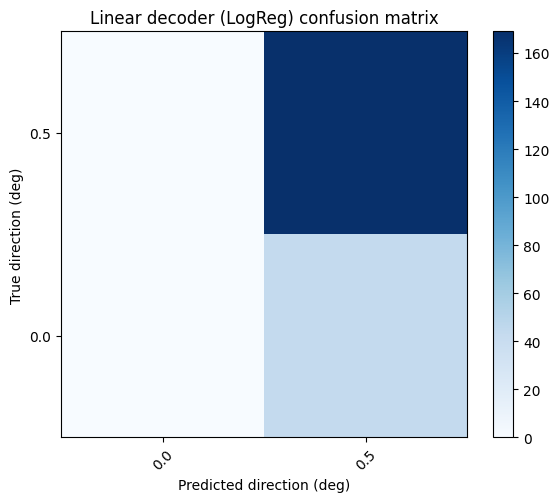

[Session 0] Linear   test acc = 0.7972
Epoch   1 | loss 0.5465 | train acc 0.7988 | test acc 0.7972
Epoch   5 | loss 0.4921 | train acc 0.7988 | test acc 0.7972
Epoch  10 | loss 0.4720 | train acc 0.7988 | test acc 0.7972
Epoch  15 | loss 0.4399 | train acc 0.8071 | test acc 0.7925
Epoch  20 | loss 0.3965 | train acc 0.8201 | test acc 0.7830
Epoch  25 | loss 0.3657 | train acc 0.8615 | test acc 0.7736
Epoch  30 | loss 0.3048 | train acc 0.8805 | test acc 0.7500
Epoch  35 | loss 0.2691 | train acc 0.9278 | test acc 0.7311
Epoch  40 | loss 0.2208 | train acc 0.9432 | test acc 0.7358
Final MLP test accuracy: 0.7358490566037735
[Session 0] MLP      test acc = 0.7358
Epoch   1 | loss 0.6964 | train acc 0.6651 | test acc 0.6745
Epoch   5 | loss 0.5219 | train acc 0.7988 | test acc 0.7972
Epoch  10 | loss 0.4926 | train acc 0.8000 | test acc 0.7972
Epoch  15 | loss 0.4784 | train acc 0.8000 | test acc 0.7972
Epoch  20 | loss 0.4397 | train acc 0.8012 | test acc 0.7972
Epoch  25 | loss 0.4198 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8038
Logistic Regression test  acc: 0.8038


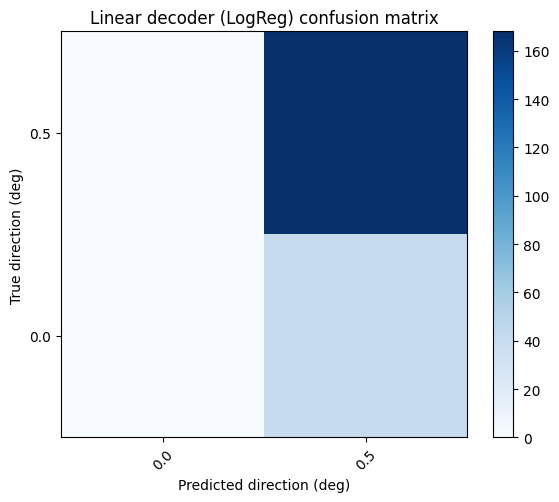

[Session 1] Linear   test acc = 0.8038
Epoch   1 | loss 0.5323 | train acc 0.8038 | test acc 0.8038
Epoch   5 | loss 0.4902 | train acc 0.8038 | test acc 0.8038
Epoch  10 | loss 0.4514 | train acc 0.8038 | test acc 0.8038
Epoch  15 | loss 0.4563 | train acc 0.8050 | test acc 0.8038
Epoch  20 | loss 0.4164 | train acc 0.8146 | test acc 0.7895
Epoch  25 | loss 0.3786 | train acc 0.8313 | test acc 0.7895
Epoch  30 | loss 0.3394 | train acc 0.8481 | test acc 0.7895
Epoch  35 | loss 0.3377 | train acc 0.8995 | test acc 0.7416
Epoch  40 | loss 0.2999 | train acc 0.8935 | test acc 0.7416
Final MLP test accuracy: 0.7416267942583732
[Session 1] MLP      test acc = 0.7416
Epoch   1 | loss 0.6817 | train acc 0.7919 | test acc 0.8038
Epoch   5 | loss 0.5124 | train acc 0.8038 | test acc 0.8038
Epoch  10 | loss 0.4846 | train acc 0.8062 | test acc 0.8038
Epoch  15 | loss 0.4860 | train acc 0.8050 | test acc 0.7990
Epoch  20 | loss 0.4607 | train acc 0.8050 | test acc 0.8038
Epoch  25 | loss 0.4495 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8022
Logistic Regression test  acc: 0.8000


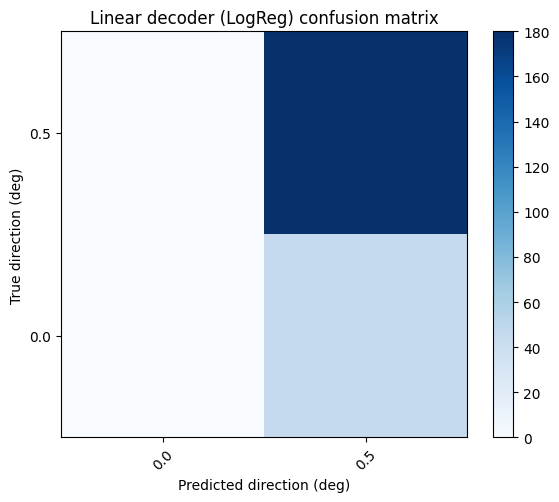

[Session 2] Linear   test acc = 0.8000
Epoch   1 | loss 0.5136 | train acc 0.8022 | test acc 0.8000
Epoch   5 | loss 0.4663 | train acc 0.8022 | test acc 0.8000
Epoch  10 | loss 0.4519 | train acc 0.8022 | test acc 0.8000
Epoch  15 | loss 0.4415 | train acc 0.8067 | test acc 0.8000
Epoch  20 | loss 0.3973 | train acc 0.8167 | test acc 0.7956
Epoch  25 | loss 0.3608 | train acc 0.8467 | test acc 0.7822
Epoch  30 | loss 0.3300 | train acc 0.8744 | test acc 0.7644
Epoch  35 | loss 0.2964 | train acc 0.8922 | test acc 0.7378
Epoch  40 | loss 0.2513 | train acc 0.8889 | test acc 0.7556
Final MLP test accuracy: 0.7555555555555555
[Session 2] MLP      test acc = 0.7556
Epoch   1 | loss 2.0378 | train acc 0.8022 | test acc 0.8000
Epoch   5 | loss 0.5047 | train acc 0.8022 | test acc 0.8000
Epoch  10 | loss 0.5068 | train acc 0.8022 | test acc 0.8000
Epoch  15 | loss 0.4834 | train acc 0.8022 | test acc 0.8000
Epoch  20 | loss 0.4592 | train acc 0.8033 | test acc 0.8000
Epoch  25 | loss 0.4404 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.7978
Logistic Regression test  acc: 0.7956


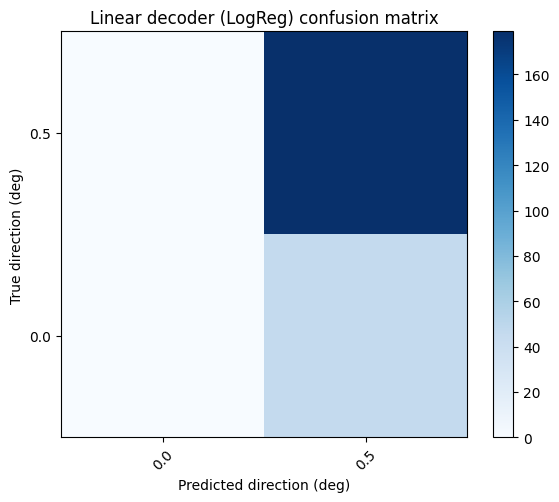

[Session 3] Linear   test acc = 0.7956
Epoch   1 | loss 0.5551 | train acc 0.7978 | test acc 0.7956
Epoch   5 | loss 0.4760 | train acc 0.7978 | test acc 0.7956
Epoch  10 | loss 0.4602 | train acc 0.7978 | test acc 0.7956
Epoch  15 | loss 0.4455 | train acc 0.8000 | test acc 0.7911
Epoch  20 | loss 0.4270 | train acc 0.8200 | test acc 0.7644
Epoch  25 | loss 0.4022 | train acc 0.8411 | test acc 0.7689
Epoch  30 | loss 0.3912 | train acc 0.8656 | test acc 0.7378
Epoch  35 | loss 0.3212 | train acc 0.8856 | test acc 0.7378
Epoch  40 | loss 0.2786 | train acc 0.9022 | test acc 0.7244
Final MLP test accuracy: 0.7244444444444444
[Session 3] MLP      test acc = 0.7244
Epoch   1 | loss 2.1247 | train acc 0.7978 | test acc 0.7956
Epoch   5 | loss 0.5068 | train acc 0.7978 | test acc 0.7956
Epoch  10 | loss 0.4972 | train acc 0.7978 | test acc 0.7956
Epoch  15 | loss 0.4841 | train acc 0.7989 | test acc 0.7822
Epoch  20 | loss 0.4674 | train acc 0.7989 | test acc 0.7956
Epoch  25 | loss 0.4428 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8244
Logistic Regression test  acc: 0.8381


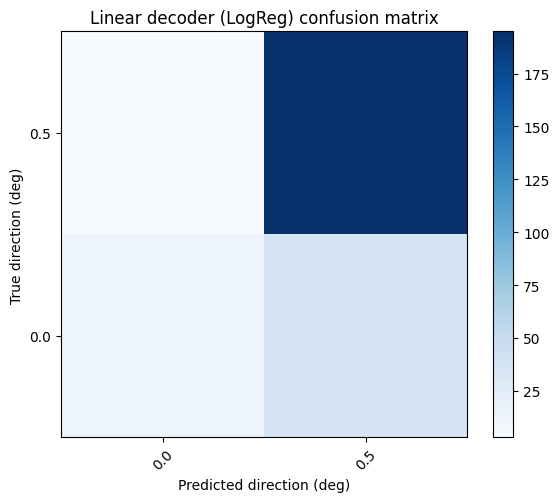

[Session 4] Linear   test acc = 0.8381
Epoch   1 | loss 0.5936 | train acc 0.8000 | test acc 0.8016
Epoch   5 | loss 0.4330 | train acc 0.8305 | test acc 0.8340
Epoch  10 | loss 0.3999 | train acc 0.8406 | test acc 0.8219
Epoch  15 | loss 0.3670 | train acc 0.8426 | test acc 0.8259
Epoch  20 | loss 0.3351 | train acc 0.8599 | test acc 0.8462
Epoch  25 | loss 0.2985 | train acc 0.8751 | test acc 0.8381
Epoch  30 | loss 0.2616 | train acc 0.8843 | test acc 0.8259
Epoch  35 | loss 0.2465 | train acc 0.8944 | test acc 0.8178
Epoch  40 | loss 0.1911 | train acc 0.9411 | test acc 0.7773
Final MLP test accuracy: 0.7773279352226721
[Session 4] MLP      test acc = 0.7773
Epoch   1 | loss 0.5679 | train acc 0.8000 | test acc 0.8016
Epoch   5 | loss 0.4427 | train acc 0.7929 | test acc 0.8016
Epoch  10 | loss 0.4198 | train acc 0.8376 | test acc 0.8178
Epoch  15 | loss 0.3992 | train acc 0.8345 | test acc 0.8300
Epoch  20 | loss 0.3766 | train acc 0.8234 | test acc 0.8300
Epoch  25 | loss 0.3604 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8125
Logistic Regression test  acc: 0.7984


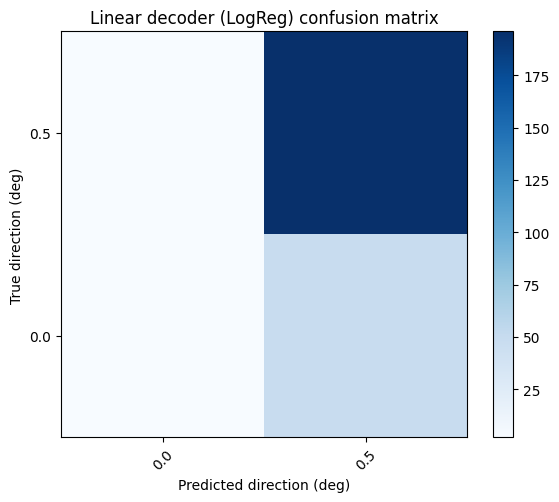

[Session 5] Linear   test acc = 0.7984
Epoch   1 | loss 0.5728 | train acc 0.8004 | test acc 0.7984
Epoch   5 | loss 0.4520 | train acc 0.8185 | test acc 0.8145
Epoch  10 | loss 0.4115 | train acc 0.8327 | test acc 0.8266
Epoch  15 | loss 0.3725 | train acc 0.8518 | test acc 0.8024
Epoch  20 | loss 0.3364 | train acc 0.8659 | test acc 0.7984
Epoch  25 | loss 0.2990 | train acc 0.8881 | test acc 0.7863
Epoch  30 | loss 0.2674 | train acc 0.8931 | test acc 0.8105
Epoch  35 | loss 0.2220 | train acc 0.9224 | test acc 0.7702
Epoch  40 | loss 0.1860 | train acc 0.9456 | test acc 0.7661
Final MLP test accuracy: 0.7661290322580645
[Session 5] MLP      test acc = 0.7661
Epoch   1 | loss 0.5938 | train acc 0.7994 | test acc 0.7984
Epoch   5 | loss 0.4637 | train acc 0.8125 | test acc 0.8065
Epoch  10 | loss 0.4395 | train acc 0.8226 | test acc 0.8145
Epoch  15 | loss 0.4144 | train acc 0.8286 | test acc 0.8185
Epoch  20 | loss 0.4051 | train acc 0.8286 | test acc 0.8226
Epoch  25 | loss 0.4028 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8269
Logistic Regression test  acc: 0.8182


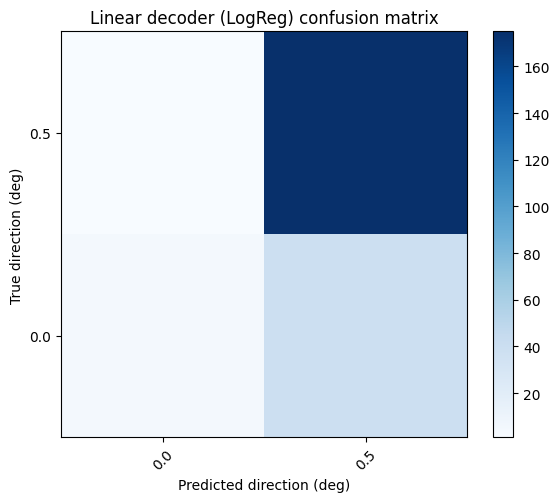

[Session 6] Linear   test acc = 0.8182
Epoch   1 | loss 0.5633 | train acc 0.8007 | test acc 0.8000
Epoch   5 | loss 0.4238 | train acc 0.8314 | test acc 0.8273
Epoch  10 | loss 0.3878 | train acc 0.8360 | test acc 0.8091
Epoch  15 | loss 0.3543 | train acc 0.8576 | test acc 0.8000
Epoch  20 | loss 0.3180 | train acc 0.8759 | test acc 0.7773
Epoch  25 | loss 0.2842 | train acc 0.8941 | test acc 0.7818
Epoch  30 | loss 0.2431 | train acc 0.9146 | test acc 0.7409
Epoch  35 | loss 0.2066 | train acc 0.9385 | test acc 0.7545
Epoch  40 | loss 0.1690 | train acc 0.9579 | test acc 0.7500
Final MLP test accuracy: 0.75
[Session 6] MLP      test acc = 0.7500
Epoch   1 | loss 0.5957 | train acc 0.8007 | test acc 0.8000
Epoch   5 | loss 0.4287 | train acc 0.8292 | test acc 0.8182
Epoch  10 | loss 0.4148 | train acc 0.8303 | test acc 0.8000
Epoch  15 | loss 0.4071 | train acc 0.8280 | test acc 0.8182
Epoch  20 | loss 0.3662 | train acc 0.8394 | test acc 0.8182
Epoch  25 | loss 0.3599 | train acc 0.

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


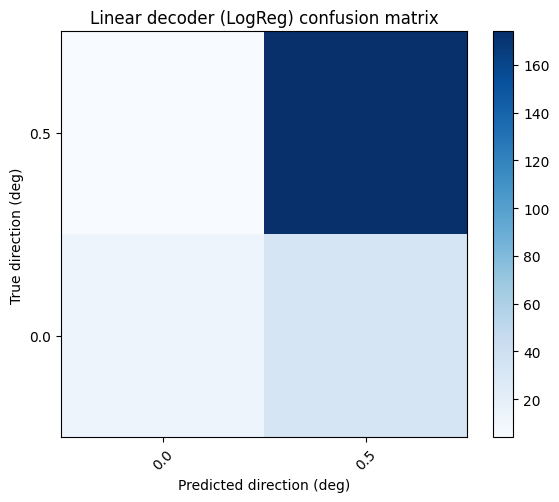

[Session 7] Linear   test acc = 0.8341
Epoch   1 | loss 0.5985 | train acc 0.7995 | test acc 0.7982
Epoch   5 | loss 0.4158 | train acc 0.8378 | test acc 0.8206
Epoch  10 | loss 0.3679 | train acc 0.8536 | test acc 0.8296
Epoch  15 | loss 0.3291 | train acc 0.8761 | test acc 0.8341
Epoch  20 | loss 0.2958 | train acc 0.8829 | test acc 0.8251
Epoch  25 | loss 0.2538 | train acc 0.9043 | test acc 0.8117
Epoch  30 | loss 0.2149 | train acc 0.9133 | test acc 0.8161
Epoch  35 | loss 0.1854 | train acc 0.9336 | test acc 0.8251
Epoch  40 | loss 0.1492 | train acc 0.9527 | test acc 0.8206
Final MLP test accuracy: 0.820627802690583
[Session 7] MLP      test acc = 0.8206
Epoch   1 | loss 0.5216 | train acc 0.8041 | test acc 0.8027
Epoch   5 | loss 0.4121 | train acc 0.8333 | test acc 0.8206
Epoch  10 | loss 0.3975 | train acc 0.8446 | test acc 0.8296
Epoch  15 | loss 0.3746 | train acc 0.8559 | test acc 0.8341
Epoch  20 | loss 0.3575 | train acc 0.8615 | test acc 0.8341
Epoch  25 | loss 0.3436 |

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


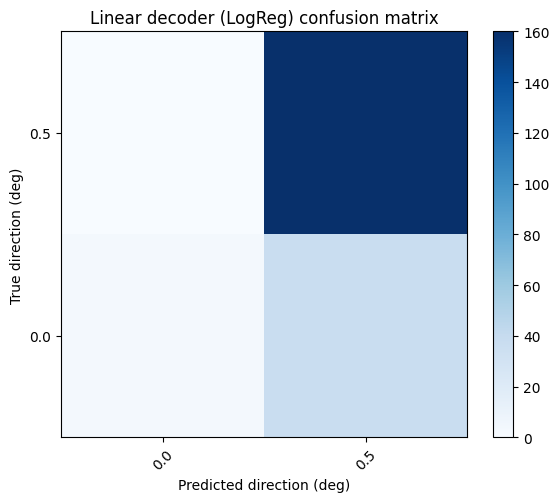

[Session 8] Linear   test acc = 0.8150
Epoch   1 | loss 0.5646 | train acc 0.7980 | test acc 0.8000
Epoch   5 | loss 0.4405 | train acc 0.8206 | test acc 0.8150
Epoch  10 | loss 0.3872 | train acc 0.8369 | test acc 0.8200
Epoch  15 | loss 0.3543 | train acc 0.8595 | test acc 0.8250
Epoch  20 | loss 0.3043 | train acc 0.8795 | test acc 0.7950
Epoch  25 | loss 0.2650 | train acc 0.8959 | test acc 0.8200
Epoch  30 | loss 0.2202 | train acc 0.9184 | test acc 0.8050
Epoch  35 | loss 0.1822 | train acc 0.9435 | test acc 0.8100
Epoch  40 | loss 0.1453 | train acc 0.9561 | test acc 0.8050
Final MLP test accuracy: 0.805
[Session 8] MLP      test acc = 0.8050
Epoch   1 | loss 0.5285 | train acc 0.8168 | test acc 0.8050
Epoch   5 | loss 0.4344 | train acc 0.8193 | test acc 0.8200
Epoch  10 | loss 0.4242 | train acc 0.8181 | test acc 0.8150
Epoch  15 | loss 0.4017 | train acc 0.8306 | test acc 0.8050
Epoch  20 | loss 0.3825 | train acc 0.8444 | test acc 0.8000
Epoch  25 | loss 0.3584 | train acc 0

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


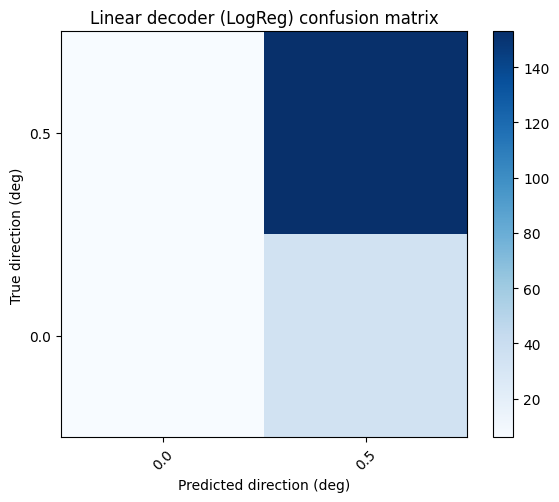

[Session 9] Linear   test acc = 0.7990
Epoch   1 | loss 0.6015 | train acc 0.7962 | test acc 0.7990
Epoch   5 | loss 0.4575 | train acc 0.8126 | test acc 0.7990
Epoch  10 | loss 0.4175 | train acc 0.8377 | test acc 0.8090
Epoch  15 | loss 0.3726 | train acc 0.8516 | test acc 0.7940
Epoch  20 | loss 0.3336 | train acc 0.8679 | test acc 0.7990
Epoch  25 | loss 0.2902 | train acc 0.8818 | test acc 0.7889
Epoch  30 | loss 0.2471 | train acc 0.9195 | test acc 0.7638
Epoch  35 | loss 0.2015 | train acc 0.9409 | test acc 0.7688
Epoch  40 | loss 0.1649 | train acc 0.9535 | test acc 0.7739
Final MLP test accuracy: 0.7738693467336684
[Session 9] MLP      test acc = 0.7739
Epoch   1 | loss 0.6647 | train acc 0.7736 | test acc 0.7337
Epoch   5 | loss 0.4725 | train acc 0.8164 | test acc 0.8090
Epoch  10 | loss 0.4427 | train acc 0.8176 | test acc 0.8191
Epoch  15 | loss 0.4296 | train acc 0.8327 | test acc 0.8141
Epoch  20 | loss 0.4043 | train acc 0.8491 | test acc 0.7588
Epoch  25 | loss 0.3813 

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


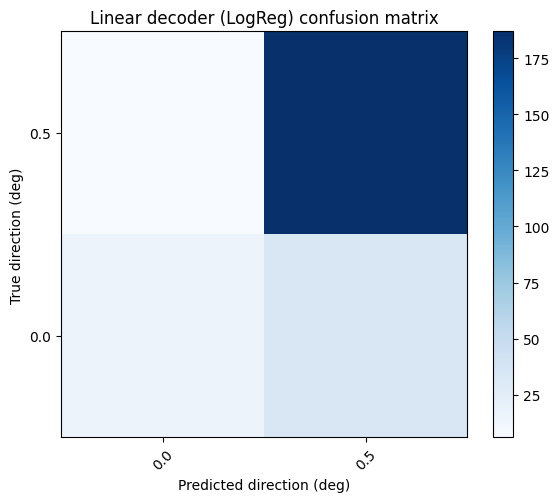

[Session 10] Linear   test acc = 0.8388
Epoch   1 | loss 0.5541 | train acc 0.7979 | test acc 0.7975
Epoch   5 | loss 0.3969 | train acc 0.8363 | test acc 0.8471
Epoch  10 | loss 0.3812 | train acc 0.8404 | test acc 0.8388
Epoch  15 | loss 0.3497 | train acc 0.8425 | test acc 0.8388
Epoch  20 | loss 0.3523 | train acc 0.8560 | test acc 0.8430
Epoch  25 | loss 0.3201 | train acc 0.8622 | test acc 0.8430
Epoch  30 | loss 0.2996 | train acc 0.8808 | test acc 0.8264
Epoch  35 | loss 0.2594 | train acc 0.8995 | test acc 0.8264
Epoch  40 | loss 0.2239 | train acc 0.9119 | test acc 0.8140
Final MLP test accuracy: 0.8140495867768595
[Session 10] MLP      test acc = 0.8140
Epoch   1 | loss 0.5352 | train acc 0.8010 | test acc 0.8099
Epoch   5 | loss 0.4076 | train acc 0.8332 | test acc 0.8430
Epoch  10 | loss 0.3929 | train acc 0.8342 | test acc 0.8388
Epoch  15 | loss 0.3898 | train acc 0.8404 | test acc 0.8347
Epoch  20 | loss 0.3834 | train acc 0.8415 | test acc 0.8347
Epoch  25 | loss 0.357

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


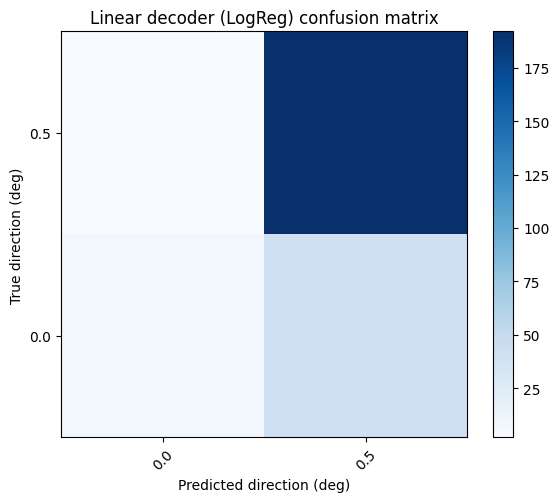

[Session 11] Linear   test acc = 0.8223
Epoch   1 | loss 0.5626 | train acc 0.8002 | test acc 0.8017
Epoch   5 | loss 0.4707 | train acc 0.8261 | test acc 0.8264
Epoch  10 | loss 0.3860 | train acc 0.8302 | test acc 0.8264
Epoch  15 | loss 0.3650 | train acc 0.8385 | test acc 0.8306
Epoch  20 | loss 0.3556 | train acc 0.8602 | test acc 0.8182
Epoch  25 | loss 0.2999 | train acc 0.8810 | test acc 0.8058
Epoch  30 | loss 0.2796 | train acc 0.8975 | test acc 0.8017
Epoch  35 | loss 0.2397 | train acc 0.9234 | test acc 0.7851
Epoch  40 | loss 0.2076 | train acc 0.9369 | test acc 0.7851
Final MLP test accuracy: 0.7851239669421488
[Session 11] MLP      test acc = 0.7851
Epoch   1 | loss 1.0294 | train acc 0.8168 | test acc 0.8099
Epoch   5 | loss 0.4374 | train acc 0.8364 | test acc 0.8223
Epoch  10 | loss 0.4024 | train acc 0.8333 | test acc 0.8388
Epoch  15 | loss 0.3845 | train acc 0.8458 | test acc 0.8347
Epoch  20 | loss 0.3752 | train acc 0.8478 | test acc 0.7934
Epoch  25 | loss 0.346

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


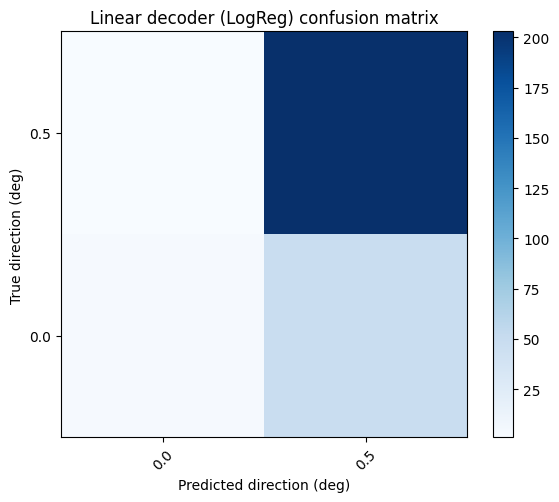

[Session 12] Linear   test acc = 0.8078
Epoch   1 | loss 0.5829 | train acc 0.8016 | test acc 0.8000
Epoch   5 | loss 0.4472 | train acc 0.8183 | test acc 0.8275
Epoch  10 | loss 0.4122 | train acc 0.8261 | test acc 0.8118
Epoch  15 | loss 0.3811 | train acc 0.8399 | test acc 0.8078
Epoch  20 | loss 0.3441 | train acc 0.8477 | test acc 0.8039
Epoch  25 | loss 0.3036 | train acc 0.8752 | test acc 0.7922
Epoch  30 | loss 0.2617 | train acc 0.8929 | test acc 0.7922
Epoch  35 | loss 0.2167 | train acc 0.9273 | test acc 0.7804
Epoch  40 | loss 0.1770 | train acc 0.9420 | test acc 0.7804
Final MLP test accuracy: 0.7803921568627451
[Session 12] MLP      test acc = 0.7804
Epoch   1 | loss 0.5147 | train acc 0.8016 | test acc 0.8000
Epoch   5 | loss 0.4392 | train acc 0.7859 | test acc 0.7725
Epoch  10 | loss 0.4430 | train acc 0.8114 | test acc 0.8196
Epoch  15 | loss 0.4139 | train acc 0.8310 | test acc 0.8196
Epoch  20 | loss 0.4006 | train acc 0.8271 | test acc 0.8235
Epoch  25 | loss 0.379

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


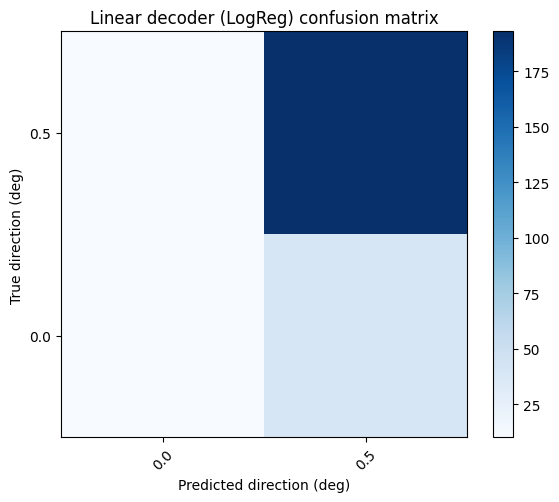

[Session 13] Linear   test acc = 0.8024
Epoch   1 | loss 0.5415 | train acc 0.8020 | test acc 0.8024
Epoch   5 | loss 0.4249 | train acc 0.8327 | test acc 0.8221
Epoch  10 | loss 0.3914 | train acc 0.8317 | test acc 0.8142
Epoch  15 | loss 0.3558 | train acc 0.8485 | test acc 0.8142
Epoch  20 | loss 0.3203 | train acc 0.8782 | test acc 0.7905
Epoch  25 | loss 0.2879 | train acc 0.8871 | test acc 0.7866
Epoch  30 | loss 0.2542 | train acc 0.9079 | test acc 0.7747
Epoch  35 | loss 0.2179 | train acc 0.9238 | test acc 0.7905
Epoch  40 | loss 0.1858 | train acc 0.9416 | test acc 0.7866
Final MLP test accuracy: 0.7865612648221344
[Session 13] MLP      test acc = 0.7866
Epoch   1 | loss 0.4496 | train acc 0.8257 | test acc 0.8300
Epoch   5 | loss 0.4257 | train acc 0.8297 | test acc 0.8261
Epoch  10 | loss 0.4047 | train acc 0.8337 | test acc 0.8063
Epoch  15 | loss 0.3920 | train acc 0.8238 | test acc 0.7352
Epoch  20 | loss 0.3743 | train acc 0.8356 | test acc 0.8142
Epoch  25 | loss 0.358

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8050
Logistic Regression test  acc: 0.8073


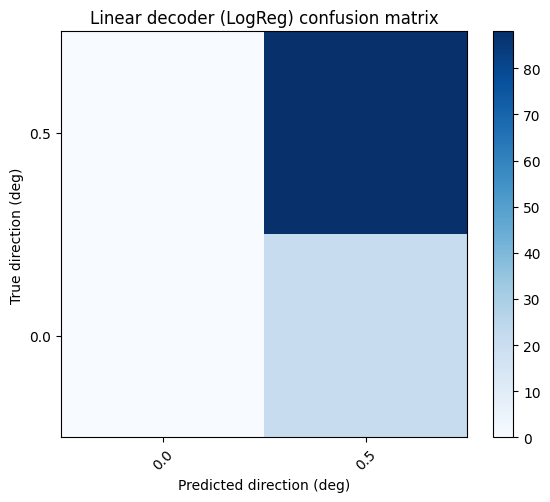

[Session 14] Linear   test acc = 0.8073
Epoch   1 | loss 0.5877 | train acc 0.8073 | test acc 0.8073
Epoch   5 | loss 0.4792 | train acc 0.8073 | test acc 0.8073
Epoch  10 | loss 0.4568 | train acc 0.8073 | test acc 0.8073
Epoch  15 | loss 0.4329 | train acc 0.8073 | test acc 0.8073
Epoch  20 | loss 0.3990 | train acc 0.8188 | test acc 0.8073
Epoch  25 | loss 0.3576 | train acc 0.8303 | test acc 0.8073
Epoch  30 | loss 0.3106 | train acc 0.8693 | test acc 0.7798
Epoch  35 | loss 0.2620 | train acc 0.9083 | test acc 0.7706
Epoch  40 | loss 0.2149 | train acc 0.9358 | test acc 0.7615
Final MLP test accuracy: 0.7614678899082569
[Session 14] MLP      test acc = 0.7615
Epoch   1 | loss 0.8187 | train acc 0.8050 | test acc 0.8073
Epoch   5 | loss 0.4883 | train acc 0.8073 | test acc 0.8073
Epoch  10 | loss 0.4576 | train acc 0.8096 | test acc 0.8073
Epoch  15 | loss 0.4284 | train acc 0.8119 | test acc 0.8073
Epoch  20 | loss 0.4122 | train acc 0.8142 | test acc 0.8073
Epoch  25 | loss 0.389

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


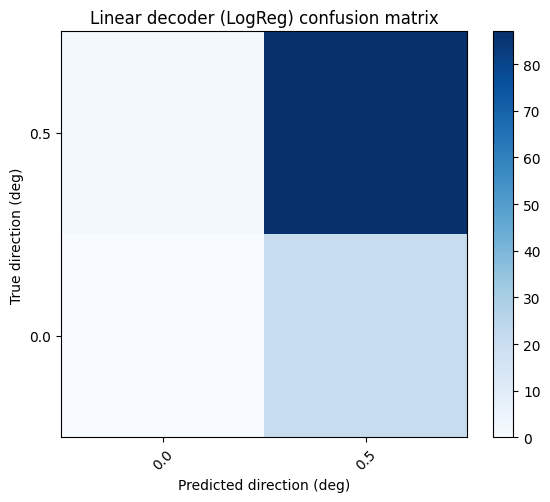

[Session 15] Linear   test acc = 0.7909
Epoch   1 | loss 0.6309 | train acc 0.8073 | test acc 0.8091
Epoch   5 | loss 0.4831 | train acc 0.8073 | test acc 0.8091
Epoch  10 | loss 0.4530 | train acc 0.8073 | test acc 0.8091
Epoch  15 | loss 0.4293 | train acc 0.8073 | test acc 0.8091
Epoch  20 | loss 0.3935 | train acc 0.8211 | test acc 0.8182
Epoch  25 | loss 0.3525 | train acc 0.8463 | test acc 0.8091
Epoch  30 | loss 0.3094 | train acc 0.8807 | test acc 0.7818
Epoch  35 | loss 0.2647 | train acc 0.9083 | test acc 0.7545
Epoch  40 | loss 0.2215 | train acc 0.9151 | test acc 0.7455
Final MLP test accuracy: 0.7454545454545455
[Session 15] MLP      test acc = 0.7455
Epoch   1 | loss 2.7396 | train acc 0.8073 | test acc 0.8091
Epoch   5 | loss 0.5543 | train acc 0.7729 | test acc 0.7727
Epoch  10 | loss 0.4923 | train acc 0.8142 | test acc 0.8091
Epoch  15 | loss 0.4602 | train acc 0.8073 | test acc 0.8091
Epoch  20 | loss 0.4481 | train acc 0.8257 | test acc 0.8000
Epoch  25 | loss 0.427

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


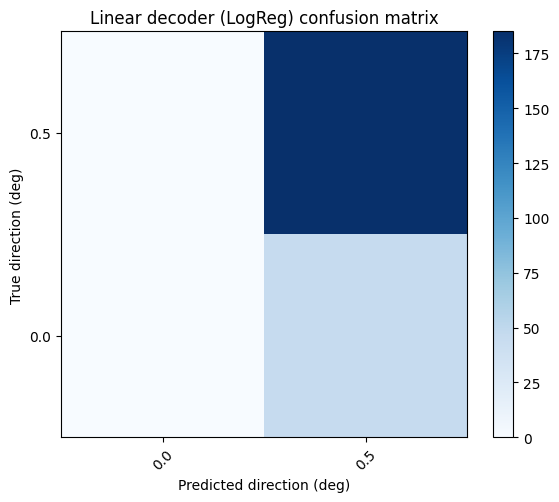

[Session 16] Linear   test acc = 0.8009
Epoch   1 | loss 0.5485 | train acc 0.7996 | test acc 0.8009
Epoch   5 | loss 0.4870 | train acc 0.7996 | test acc 0.8009
Epoch  10 | loss 0.4648 | train acc 0.7996 | test acc 0.8009
Epoch  15 | loss 0.4203 | train acc 0.8169 | test acc 0.8009
Epoch  20 | loss 0.3800 | train acc 0.8299 | test acc 0.8052
Epoch  25 | loss 0.3276 | train acc 0.8592 | test acc 0.7792
Epoch  30 | loss 0.2698 | train acc 0.9133 | test acc 0.7619
Epoch  35 | loss 0.2198 | train acc 0.9307 | test acc 0.7749
Epoch  40 | loss 0.1787 | train acc 0.9642 | test acc 0.7576
Final MLP test accuracy: 0.7575757575757576
[Session 16] MLP      test acc = 0.7576
Epoch   1 | loss 1.7644 | train acc 0.7996 | test acc 0.8009
Epoch   5 | loss 0.5055 | train acc 0.7996 | test acc 0.8009
Epoch  10 | loss 0.4825 | train acc 0.7996 | test acc 0.8009
Epoch  15 | loss 0.4777 | train acc 0.8039 | test acc 0.7965
Epoch  20 | loss 0.4764 | train acc 0.7356 | test acc 0.6926
Epoch  25 | loss 0.462

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


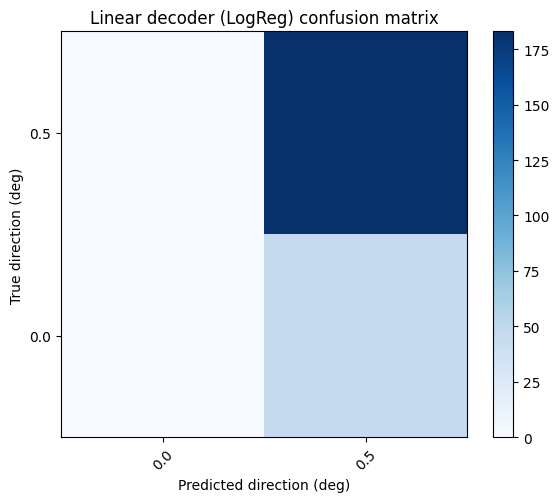

[Session 17] Linear   test acc = 0.7991
Epoch   1 | loss 0.5517 | train acc 0.8007 | test acc 0.7991
Epoch   5 | loss 0.4857 | train acc 0.8007 | test acc 0.7991
Epoch  10 | loss 0.4631 | train acc 0.8007 | test acc 0.7991
Epoch  15 | loss 0.4323 | train acc 0.8105 | test acc 0.7991
Epoch  20 | loss 0.3995 | train acc 0.8248 | test acc 0.7817
Epoch  25 | loss 0.3639 | train acc 0.8445 | test acc 0.7424
Epoch  30 | loss 0.3400 | train acc 0.8697 | test acc 0.7293
Epoch  35 | loss 0.2953 | train acc 0.8861 | test acc 0.7336
Epoch  40 | loss 0.2553 | train acc 0.9146 | test acc 0.7031
Final MLP test accuracy: 0.7030567685589519
[Session 17] MLP      test acc = 0.7031
Epoch   1 | loss 0.6971 | train acc 0.8007 | test acc 0.7904
Epoch   5 | loss 0.4982 | train acc 0.8007 | test acc 0.7991
Epoch  10 | loss 0.4868 | train acc 0.8007 | test acc 0.7991
Epoch  15 | loss 0.4792 | train acc 0.8007 | test acc 0.7991
Epoch  20 | loss 0.4811 | train acc 0.8061 | test acc 0.7948
Epoch  25 | loss 0.468

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


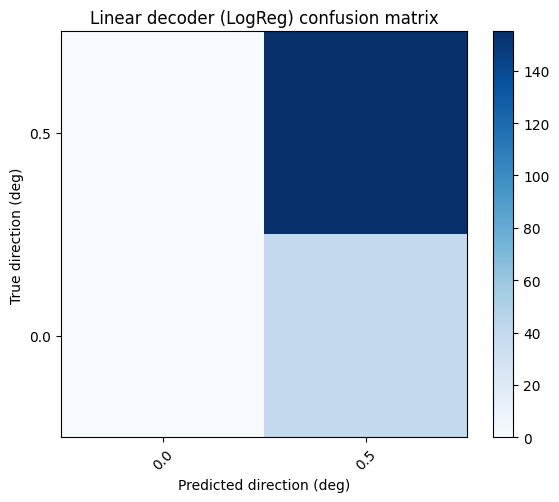

[Session 18] Linear   test acc = 0.7990
Epoch   1 | loss 0.6016 | train acc 0.7997 | test acc 0.7990
Epoch   5 | loss 0.5154 | train acc 0.7997 | test acc 0.7990
Epoch  10 | loss 0.4740 | train acc 0.7997 | test acc 0.7990
Epoch  15 | loss 0.4569 | train acc 0.8023 | test acc 0.7990
Epoch  20 | loss 0.4181 | train acc 0.8010 | test acc 0.7938
Epoch  25 | loss 0.3968 | train acc 0.8217 | test acc 0.7629
Epoch  30 | loss 0.3783 | train acc 0.8540 | test acc 0.7629
Epoch  35 | loss 0.2996 | train acc 0.8837 | test acc 0.7526
Epoch  40 | loss 0.2460 | train acc 0.9160 | test acc 0.7423
Final MLP test accuracy: 0.7422680412371134
[Session 18] MLP      test acc = 0.7423
Epoch   1 | loss 0.5886 | train acc 0.7636 | test acc 0.7629
Epoch   5 | loss 0.4950 | train acc 0.7997 | test acc 0.7990
Epoch  10 | loss 0.4959 | train acc 0.7997 | test acc 0.7990
Epoch  15 | loss 0.4975 | train acc 0.8036 | test acc 0.7990
Epoch  20 | loss 0.4730 | train acc 0.8023 | test acc 0.7938
Epoch  25 | loss 0.447

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


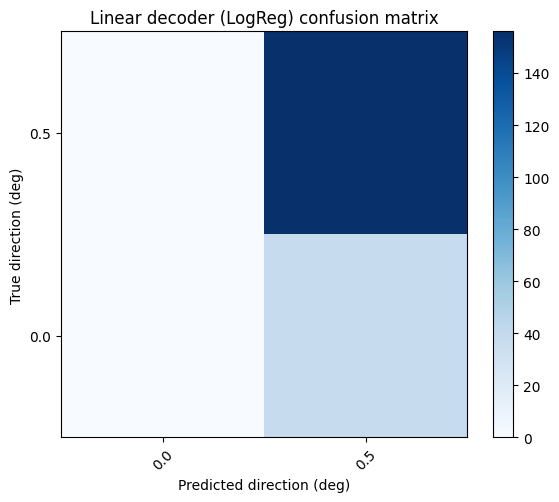

[Session 19] Linear   test acc = 0.8041
Epoch   1 | loss 0.5528 | train acc 0.8034 | test acc 0.8041
Epoch   5 | loss 0.4576 | train acc 0.8034 | test acc 0.8041
Epoch  10 | loss 0.4457 | train acc 0.8034 | test acc 0.8041
Epoch  15 | loss 0.4261 | train acc 0.8047 | test acc 0.8041
Epoch  20 | loss 0.3947 | train acc 0.8137 | test acc 0.7938
Epoch  25 | loss 0.4075 | train acc 0.8409 | test acc 0.7732
Epoch  30 | loss 0.3276 | train acc 0.8590 | test acc 0.7732
Epoch  35 | loss 0.2962 | train acc 0.8706 | test acc 0.7680
Epoch  40 | loss 0.2822 | train acc 0.8875 | test acc 0.7835
Final MLP test accuracy: 0.7835051546391752
[Session 19] MLP      test acc = 0.7835
Epoch   1 | loss 1.9488 | train acc 0.8034 | test acc 0.8041
Epoch   5 | loss 0.5234 | train acc 0.8034 | test acc 0.8041
Epoch  10 | loss 0.5294 | train acc 0.8021 | test acc 0.7938
Epoch  15 | loss 0.4774 | train acc 0.8047 | test acc 0.7887
Epoch  20 | loss 0.4938 | train acc 0.8021 | test acc 0.6959
Epoch  25 | loss 0.476

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


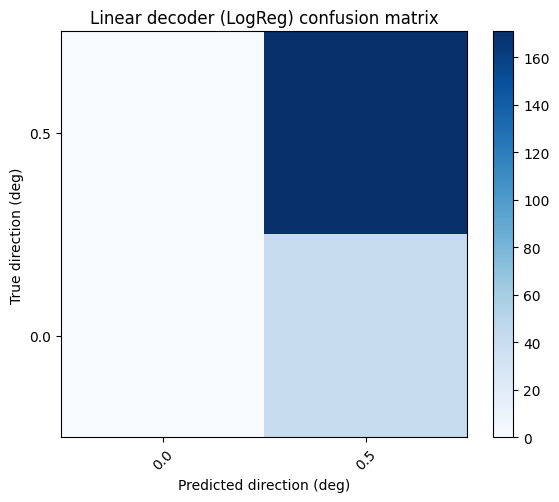

[Session 20] Linear   test acc = 0.8028
Epoch   1 | loss 0.6311 | train acc 0.8002 | test acc 0.8028
Epoch   5 | loss 0.5038 | train acc 0.8002 | test acc 0.8028
Epoch  10 | loss 0.4672 | train acc 0.8002 | test acc 0.8028
Epoch  15 | loss 0.4569 | train acc 0.8002 | test acc 0.8028
Epoch  20 | loss 0.4245 | train acc 0.8143 | test acc 0.7981
Epoch  25 | loss 0.3735 | train acc 0.8367 | test acc 0.7840
Epoch  30 | loss 0.3324 | train acc 0.8555 | test acc 0.7700
Epoch  35 | loss 0.2890 | train acc 0.8966 | test acc 0.7512
Epoch  40 | loss 0.2523 | train acc 0.9048 | test acc 0.7512
Final MLP test accuracy: 0.7511737089201878
[Session 20] MLP      test acc = 0.7512
Epoch   1 | loss 0.5696 | train acc 0.7991 | test acc 0.8075
Epoch   5 | loss 0.5035 | train acc 0.8002 | test acc 0.8028
Epoch  10 | loss 0.5082 | train acc 0.8026 | test acc 0.7981
Epoch  15 | loss 0.4742 | train acc 0.8038 | test acc 0.7981
Epoch  20 | loss 0.4515 | train acc 0.8120 | test acc 0.7700
Epoch  25 | loss 0.450

c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


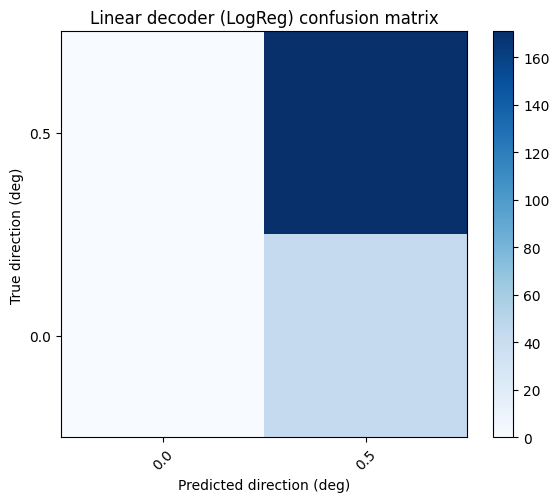

[Session 21] Linear   test acc = 0.7991
Epoch   1 | loss 0.5692 | train acc 0.8002 | test acc 0.7991
Epoch   5 | loss 0.4943 | train acc 0.8002 | test acc 0.7991
Epoch  10 | loss 0.4621 | train acc 0.8002 | test acc 0.7991
Epoch  15 | loss 0.4365 | train acc 0.8037 | test acc 0.7991
Epoch  20 | loss 0.4077 | train acc 0.8213 | test acc 0.7897
Epoch  25 | loss 0.3616 | train acc 0.8528 | test acc 0.7757
Epoch  30 | loss 0.3111 | train acc 0.8738 | test acc 0.7570
Epoch  35 | loss 0.2615 | train acc 0.9100 | test acc 0.7523
Epoch  40 | loss 0.2108 | train acc 0.9416 | test acc 0.7430
Final MLP test accuracy: 0.7429906542056075
[Session 21] MLP      test acc = 0.7430
Epoch   1 | loss 0.5805 | train acc 0.8002 | test acc 0.7991
Epoch   5 | loss 0.4959 | train acc 0.8014 | test acc 0.7991
Epoch  10 | loss 0.4863 | train acc 0.8014 | test acc 0.7944
Epoch  15 | loss 0.4791 | train acc 0.8061 | test acc 0.7757
Epoch  20 | loss 0.4773 | train acc 0.8026 | test acc 0.7710
Epoch  25 | loss 0.453

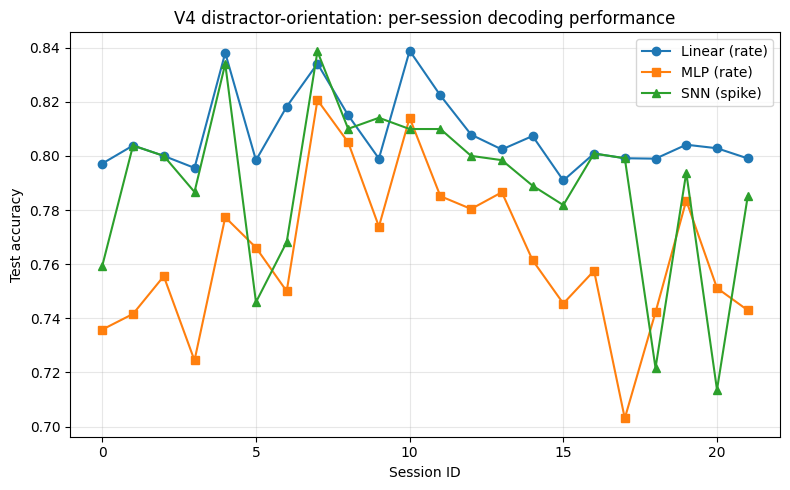

In [ ]:
# 批量跑 HenryKohn2022_distractororientation_session{0..21}_v4.npz 的实验
# 需要你已经实现好：
#   - decoding/linear_decoder.py   中的 train_and_eval_linear
#   - decoding/rate_decoder_mlp.py 中的 train_rate_mlp
#   - decoding/snn_decoder.py      中的 train_snn_decoder

import os
import numpy as np
import matplotlib.pyplot as plt

from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

# ---------- 配置部分 ----------
# 存放 per-session npz 的目录
base_dir = r"D:\Neuron Science\FinPro\npz_data"   # 改成你自己的路径
# session 范围：0 ~ 21
session_ids = list(range(22))
# 训练集划分比例 & 随机种子
test_size = 0.2
random_state = 0

# MLP / SNN 的训练 epoch（可以根据实际速度调小/调大）
mlp_epochs = 40
snn_epochs = 40

# ---------- 存结果 ----------
linear_accs = []
mlp_accs = []
snn_accs = []
used_sessions = []  # 实际成功跑到的 session id

# ---------- 主循环：逐 session 做实验 ----------
for sid in session_ids:
    fname = f"HenryKohn2022_distractorseparation_session{sid}_v4.npz"
    dataset_path = os.path.join(base_dir, fname)

    if not os.path.exists(dataset_path):
        print(f"[Session {sid}] 文件不存在，跳过: {dataset_path}")
        continue

    print(f"\n================ Session {sid} ================")
    print(f"加载数据: {dataset_path}")

    # ----- Linear (rate-based baseline) -----
    try:
        _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
        )
        print(f"[Session {sid}] Linear   test acc = {test_acc_lin:.4f}")
    except Exception as e:
        print(f"[Session {sid}] Linear 训练/测试出错：{e}")
        test_acc_lin = np.nan

    # ----- MLP (rate-based) -----
    try:
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
            n_epochs=mlp_epochs,
        )
        print(f"[Session {sid}] MLP      test acc = {test_acc_mlp:.4f}")
    except Exception as e:
        print(f"[Session {sid}] MLP 训练/测试出错：{e}")
        test_acc_mlp = np.nan

    # ----- SNN (spike-train based) -----
    try:
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
            n_epochs=snn_epochs,
        )
        print(f"[Session {sid}] SNN      test acc = {test_acc_snn:.4f}")
    except Exception as e:
        print(f"[Session {sid}] SNN 训练/测试出错：{e}")
        test_acc_snn = np.nan

    used_sessions.append(sid)
    linear_accs.append(test_acc_lin)
    mlp_accs.append(test_acc_mlp)
    snn_accs.append(test_acc_snn)

# ---------- 汇总为 numpy 数组 ----------
used_sessions = np.array(used_sessions)
linear_accs = np.array(linear_accs, dtype=float)
mlp_accs = np.array(mlp_accs, dtype=float)
snn_accs = np.array(snn_accs, dtype=float)

print("\n========== 总结 ==========")
for sid, la, ma, sa in zip(used_sessions, linear_accs, mlp_accs, snn_accs):
    print(f"Session {sid:2d} | Linear: {la:.4f} | MLP: {ma:.4f} | SNN: {sa:.4f}")

# ---------- 画图 ----------
plt.figure(figsize=(8, 5))
plt.plot(used_sessions, linear_accs, marker="o", label="Linear (rate)")
plt.plot(used_sessions, mlp_accs, marker="s", label="MLP (rate)")
plt.plot(used_sessions, snn_accs, marker="^", label="SNN (spike)")
plt.xlabel("Session ID")
plt.ylabel("Test accuracy")
plt.title("V4 distractor-orientation: per-session decoding performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


加载大数据集： D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractorseparation_all_sessions_v4.npz
X_train shape: (18744, 14) X_test shape: (4687, 14)
y_train distribution: {0: 3740, 1: 15004}
y_test  distribution: {0: 935, 1: 3752}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8005
Logistic Regression test  acc: 0.8005


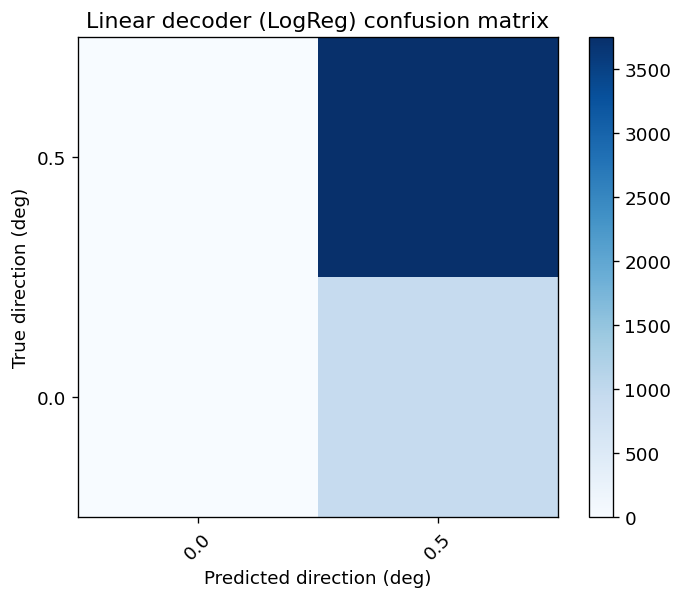

[Linear Rate] train acc = 0.8005, test acc = 0.8005
Epoch   1 | loss 0.4960 | train acc 0.8114 | test acc 0.8114
Epoch   5 | loss 0.4658 | train acc 0.8155 | test acc 0.8135
Epoch  10 | loss 0.4554 | train acc 0.8168 | test acc 0.8146
Epoch  15 | loss 0.4444 | train acc 0.8171 | test acc 0.8103
Epoch  20 | loss 0.4346 | train acc 0.8204 | test acc 0.8140
Epoch  25 | loss 0.4244 | train acc 0.8244 | test acc 0.8125
Epoch  30 | loss 0.4135 | train acc 0.8276 | test acc 0.8093
Epoch  35 | loss 0.4025 | train acc 0.8317 | test acc 0.8054
Epoch  40 | loss 0.3904 | train acc 0.8348 | test acc 0.7945
Final MLP test accuracy: 0.7945380840623
[MLP Rate]   test acc = 0.7945
Epoch   1 | loss 0.5091 | train acc 0.8099 | test acc 0.8103
Epoch   5 | loss 0.4770 | train acc 0.8158 | test acc 0.8131
Epoch  10 | loss 0.4678 | train acc 0.8165 | test acc 0.8135
Epoch  15 | loss 0.4646 | train acc 0.8167 | test acc 0.8129
Epoch  20 | loss 0.4609 | train acc 0.8175 | test acc 0.8131
Epoch  25 | loss 0.458

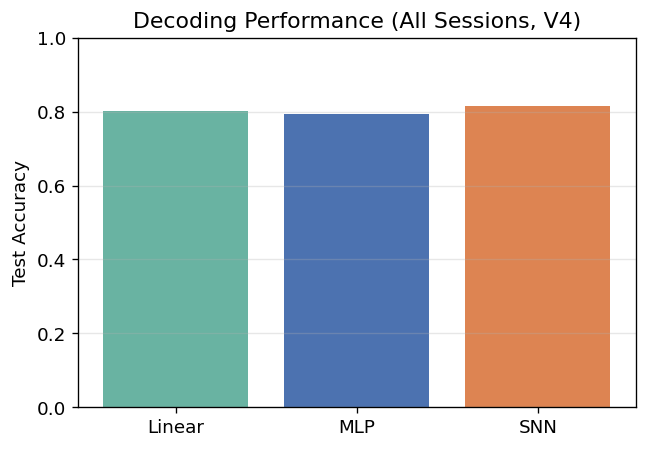

In [18]:
# ==== 实验：使用 HenryKohn2022_distractororientation_all_sessions_v4.npz ====

import os
import numpy as np
import matplotlib.pyplot as plt

from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

# ---------- 配置 ----------
npz_path = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractorseparation_all_sessions_v4.npz"
test_size = 0.2
random_state = 0
mlp_epochs = 40
snn_epochs = 40

print("加载大数据集：", npz_path)


# ========== Linear baseline ==========
lin_model, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
    dataset_path=npz_path,
    test_size=test_size,
    random_state=random_state,
)
print(f"[Linear Rate] train acc = {train_acc_lin:.4f}, test acc = {test_acc_lin:.4f}")


# ========== MLP rate decoder ==========
mlp_model, (test_acc_mlp, mlp_history) = train_rate_mlp(
    dataset_path=npz_path,
    test_size=test_size,
    random_state=random_state,
    n_epochs=mlp_epochs,
)
print(f"[MLP Rate]   test acc = {test_acc_mlp:.4f}")


# ========== SNN decoder ==========
snn_model, (test_acc_snn, snn_history) = train_snn_decoder(
    dataset_path=npz_path,
    test_size=test_size,
    random_state=random_state,
    n_epochs=snn_epochs,
)
print(f"[SNN Spike]  test acc = {test_acc_snn:.4f}")


# ---------- 展示结果 ----------
print("\n=== Summary ===")
print(f"Linear : {test_acc_lin:.4f}")
print(f"MLP    : {test_acc_mlp:.4f}")
print(f"SNN    : {test_acc_snn:.4f}")

plt.figure(figsize=(6,4))
plt.bar(["Linear","MLP","SNN"],
        [test_acc_lin, test_acc_mlp, test_acc_snn],
        color=["#69b3a2","#4c72b0","#dd8452"])
plt.ylabel("Test Accuracy")
plt.title("Decoding Performance (All Sessions, V4)")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.show()





In [20]:
#打印HenryKohn2022_distractororientation_all_sessions_v4.npz数据集中的内容
data = np.load(npz_path, allow_pickle=True)
print("数据集包含的键：", data.files)   
for key in data.files:
    print(f"\n键: {key}")
    print("内容:", data[key])
    print("形状:", data[key].shape if hasattr(data[key], 'shape') else 'N/A')
    print("数据类型:", data[key].dtype if hasattr(data[key], 'dtype') else  'N/A')
    

数据集包含的键： ['spikes', 'spikecounts', 'labels', 'directions_deg', 'session_idx', 'meta']

键: spikes
内容: [[[0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  ...
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]]

 [[0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  ...
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]]

 [[0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  ...
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]]

 ...

 [[0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  ...
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 

In [22]:
import h5py

mat_path = "D:\\Neuron Science\\FinPro\\mat_data\\HenryKohn2022_distractororientation.mat"
with h5py.File(mat_path, "r") as f:
    def print_h5_group(name, obj):
        print(f"== {name} ==")
        if isinstance(obj, h5py.Dataset):
            print(obj[()])     # 打印数据
        print()

    f.visititems(print_h5_group)


OSError: Unable to synchronously open file (file signature not found)